In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

# Helper Functions 

In [2]:
def cross_validation(x_training,kfold,model_name,model,verbose = False):
    k=1
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'\n KFold Number:{k}')
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] < validation_end_date)]

        #training
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)
        #prediction
        yhat = m.predict(xvalidation)
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        print(m_result)

        #store performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({ 'Model Name': model_name, 
          'MAE': np.round(np.mean(mae_list),2).astype(str)+'+/-'+np.round(np.std(mae_list),2).astype(str),
         'MAPE': np.round(np.mean(mape_list),2).astype(str)+'+/-'+np.round(np.std(mape_list),2).astype(str),
         'RMSE': np.round(np.mean(rmse_list),2).astype(str)+'+/-'+np.round(np.std(rmse_list),2).astype(str)},index = [0])



def mean_percentage_error(y, yhat):
    return np.mean( (y-yhat) /y )



def ml_error(model_name,y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y , yhat)
    rmse = np.sqrt(mean_squared_error(y , yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE':mape,
                          'RMSE': rmse}, index = [0])



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading data

In [4]:
df_store_raw = pd.read_csv('store.csv', low_memory = False)
df_train_raw = pd.read_csv('train.csv', low_memory = False)

df_raw = pd.merge(df_train_raw, df_store_raw, how = 'left', on = 'Store')



In [5]:
#df_raw.info

# 1.0 Descrição dos dados

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

# 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

# 1.2 Data Dimension

In [10]:
print (f'Number of rows: {df1.shape[0]}')
print (f'Number of cols: {df1.shape[1]}')

Number of rows: 1017209
Number of cols: 18


# 1.3 Data types

In [11]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4 Check NA

In [12]:
missing_data = pd.DataFrame({'total_missing': df1.isna().sum(), '%_missing': (df1.isna().sum()/1017209)*100}) 
missing_data

,total_missing,%_missing
store,0,0.000000
day_of_week,0,0.000000
date,0,0.000000
sales,0,0.000000
customers,0,0.000000
open,0,0.000000
promo,0,0.000000
state_holiday,0,0.000000
school_holiday,0,0.000000
store_type,0,0.000000


In [13]:
null_data1 = df1[df1['promo2_since_week'].isnull() ]
null_data1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN


# 1.5 Fillout NA

In [14]:
#competition_distance
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1:'Jan',2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo']= df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

In [15]:
df1.sample(5).T

,581227,912746,294976,28576,310618
store,1098,347,755,702,446
day_of_week,1,4,4,1,1
date,2014-01-27 00:00:00,2013-04-04 00:00:00,2014-10-30 00:00:00,2015-07-06 00:00:00,2014-10-13 00:00:00
sales,4854,3744,11859,3557,4289
customers,738,324,1054,310,630
open,1,1,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,1
store_type,a,d,d,a,a


# 1.6 change types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes( include = ['int64','int32','float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','int32','datetime64[ns]'])

In [19]:
#Central tendency -Mean,Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion -- std,min,max,range,skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(min)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','max','min','range','mean','median','std','skew','kurtosis']

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1115.0,1.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,7.0,1.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,41551.0,0.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,7388.0,0.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,1.0,0.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,1.0,0.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,1.0,0.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,200000.0,20.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,12.0,1.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2015.0,1900.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


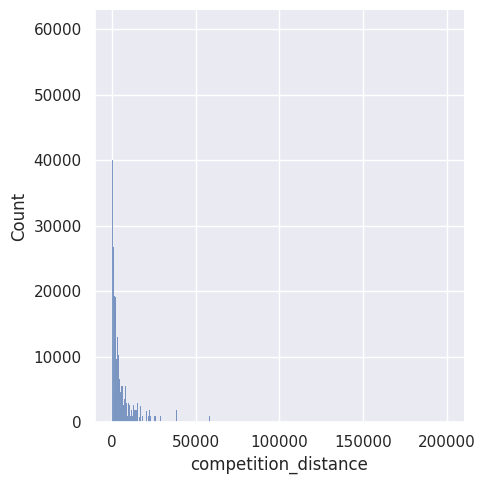

In [21]:
sns.displot(df1['competition_distance'])

# 1.7.1 Categorical attributes

In [22]:
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

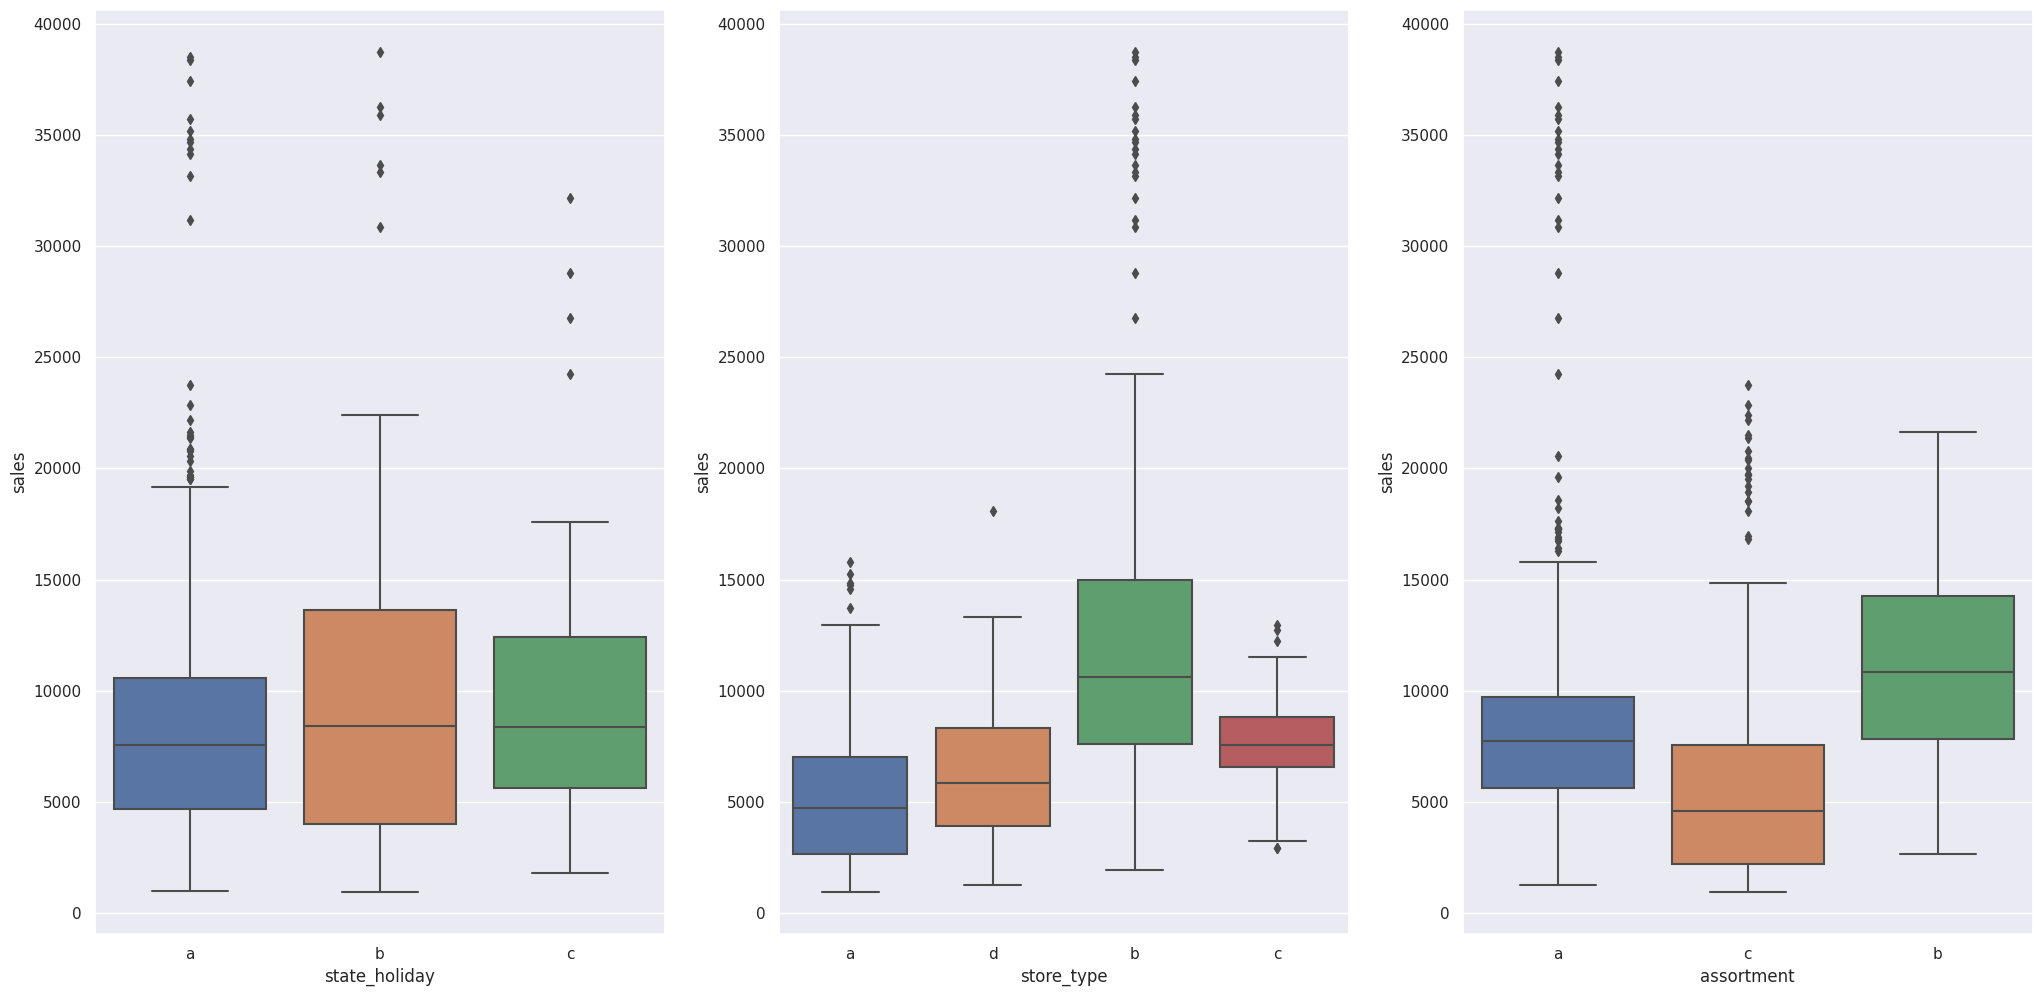

In [23]:
aux1 = df1[(df1['state_holiday']!= '0' ) & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot(x = 'state_holiday',y = 'sales',data = aux1)
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )


In [24]:
def frequency_table(data:pd.DataFrame, col:str, column:str):
    freq_table = pd.crosstab(index=data[col], columns=data[column],          margins=True)
    rel_table = round(freq_table/freq_table.loc["All"], 2)
    return freq_table, rel_table

In [25]:
a,b = frequency_table(cat_attributes,'assortment','store_type')
print(a)
print('-----------------------------------------------')
print(b)

store_type       a      b       c       d      All
assortment                                        
a           346389   6594   70878  113584   537445
b                0   8294       0       0     8294
c           205238    942   65962  199328   471470
All         551627  15830  136840  312912  1017209
-----------------------------------------------
store_type     a     b     c     d   All
assortment                              
a           0.63  0.42  0.52  0.36  0.53
b           0.00  0.52  0.00  0.00  0.01
c           0.37  0.06  0.48  0.64  0.46
All         1.00  1.00  1.00  1.00  1.00


# 2.0 Feature engineering

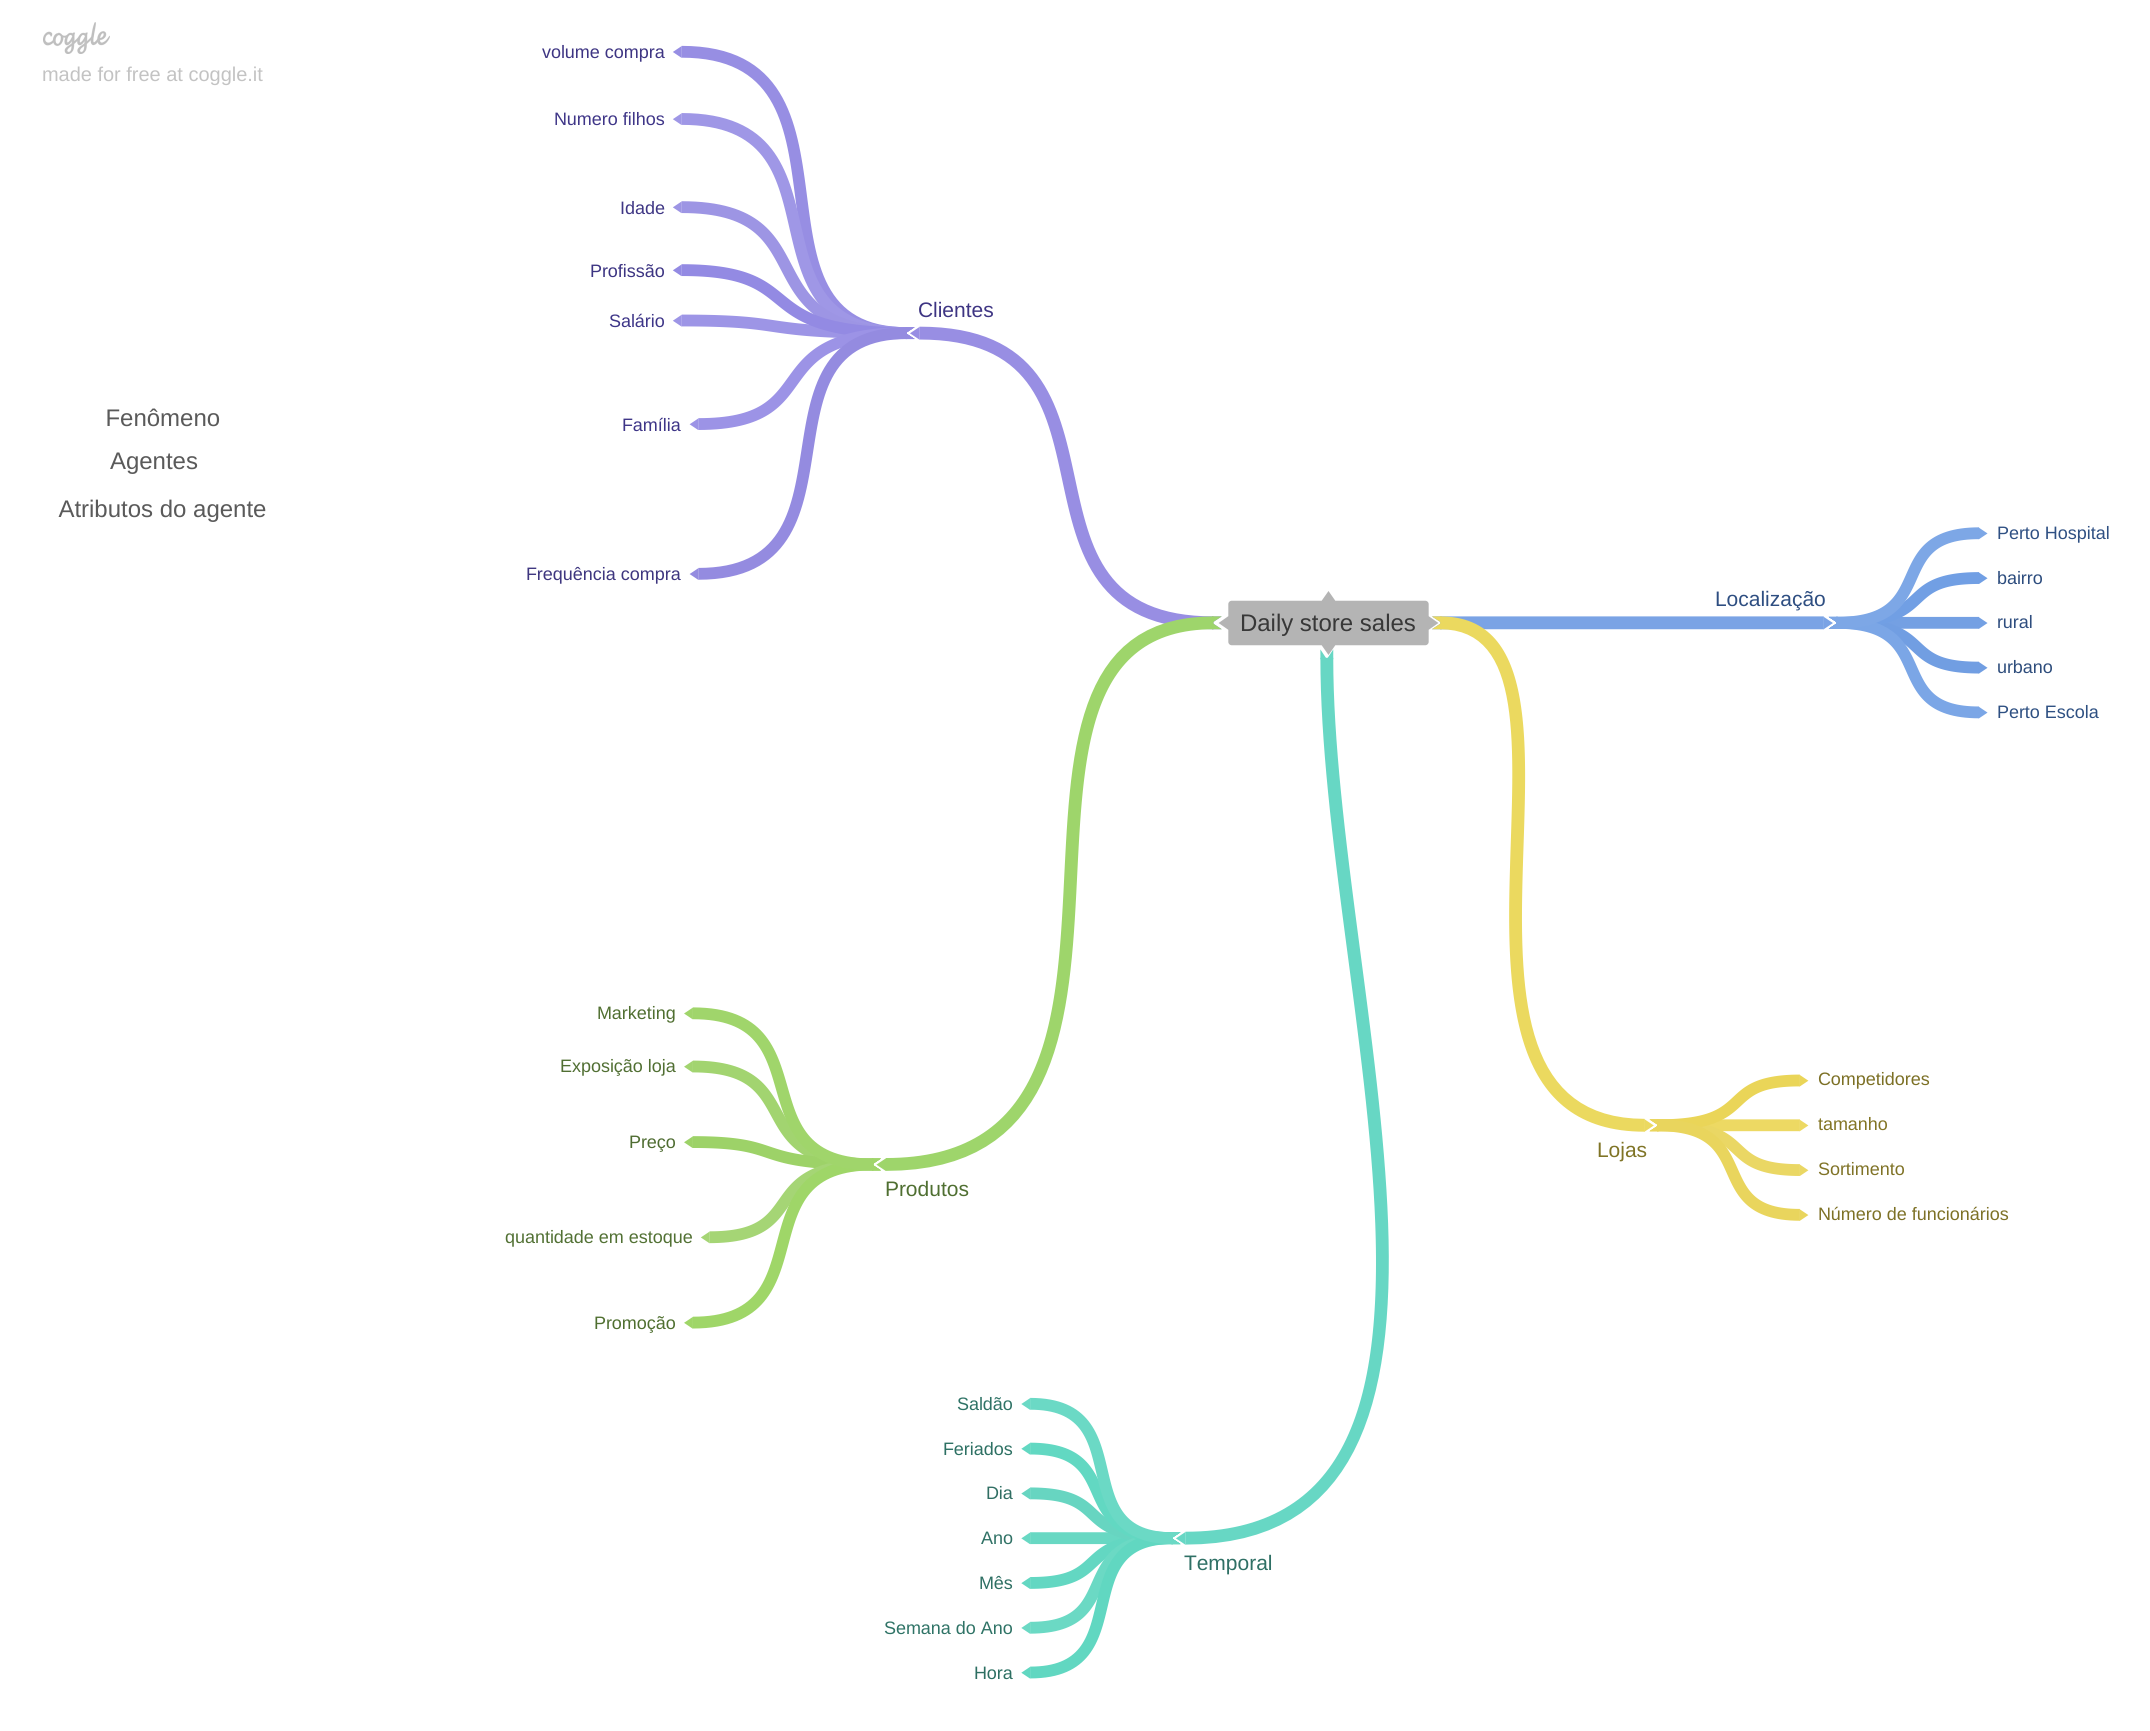

In [26]:
Image ('a1.png')

# 2.1 Criação de Hipóteses

Nessa etapa, o ideal é sentar com seu time de negócios e através do mindmap, levantar hpóteses viáveis dentro do seu banco de dados

# 2.1.1 Hipoteses loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender mais

**5.** Lojas com maior sortimento deveriam vender mais

**6.** Lojas com competidores mais próximos deveriam vender menos

**7.** Lojas com competidores a mais tempo deveriam vender mais


# 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos na vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas com promoções mais agressivas(descontos maiores) nos produtos deveriam vender mais

**5.** Lojas com promoções mais aativas por mais tempo nos produtos deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais


**7.** Lojas com mais promoções consecutivas deveriam vender mais


# 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender menos

**3.** Lojas que abrem nos finais de semana deveriam vender mais

**4.** Lojas abertas durante o feriado de natal deveriam vender mais

**5.** Lojas deveriam vender mais ao longo dos anos

**6.** Lojas deveriam vender mais no segundo semestre do ano

**7.** Lojas deveriam vender mais depois do dia 10 do mês

**8.** Lojas deveriam vender menos aos finais de semana

**9.** Lojas deveriam vender menos durante feriados escolares



# 2.2 Lista final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais


**4.** Lojas com promoções mais aativas por mais tempo nos produtos deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais


**6.** Lojas com mais promoções consecutivas deveriam vender mais


**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 do mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante feriados escolares

# 2.3 Feature Engineering

In [27]:
df2 = df1.copy()

In [28]:
#year
df2['year'] = df2['date'].dt.year
#month

df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS






In [30]:
df3 = df2.copy()

# 3.1. Filtragem das Linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

# 3.2. Selecao das Colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - análise exploratória de dados


In [33]:
df4 = df3.copy()

# 4.1. Análise univariada

# 4.1.1 Response Variable

<AxesSubplot: xlabel='sales', ylabel='Density'>

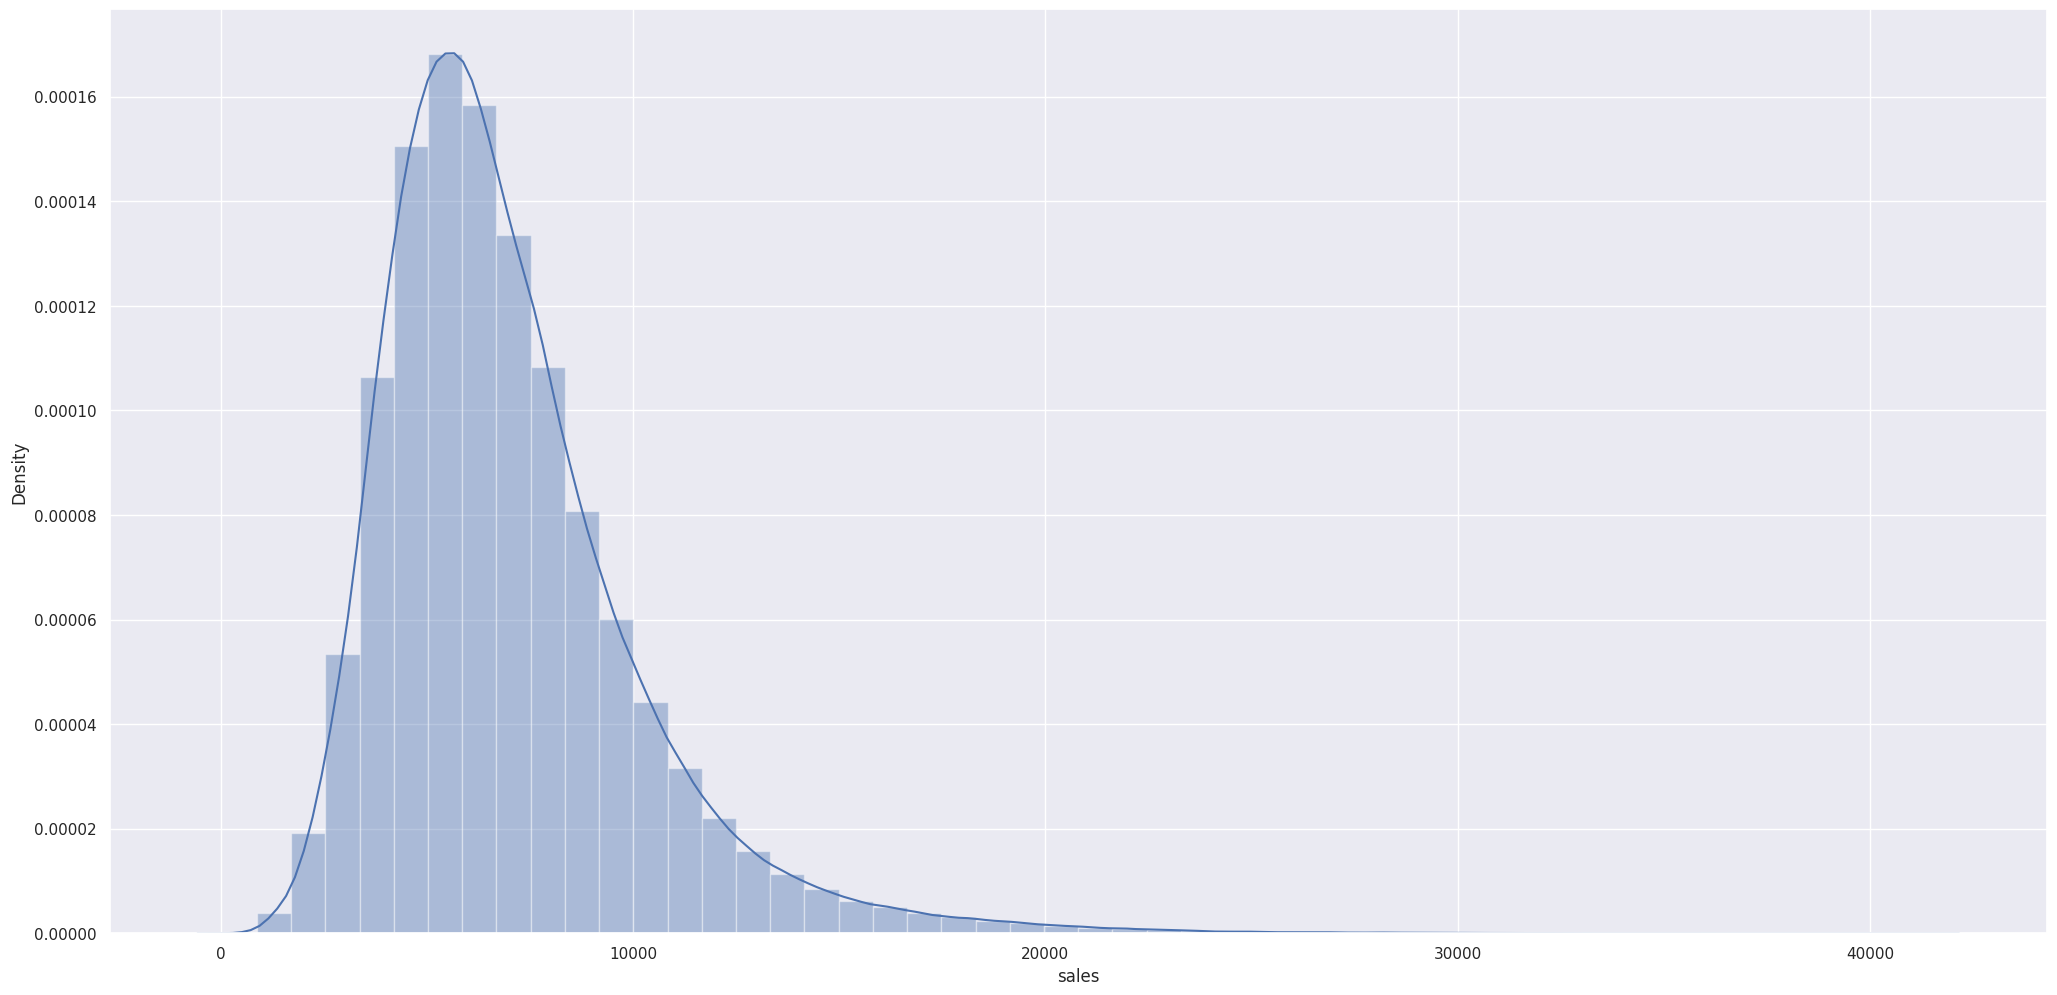

In [34]:
sns.distplot(df4['sales'])

# 4.1.2 Numerical Variable

array([[<AxesSubplot: title={'center': 'store'}>,
        <AxesSubplot: title={'center': 'day_of_week'}>,
        <AxesSubplot: title={'center': 'sales'}>,
        <AxesSubplot: title={'center': 'customers'}>],
       [<AxesSubplot: title={'center': 'open'}>,
        <AxesSubplot: title={'center': 'promo'}>,
        <AxesSubplot: title={'center': 'school_holiday'}>,
        <AxesSubplot: title={'center': 'competition_distance'}>],
       [<AxesSubplot: title={'center': 'competition_open_since_month'}>,
        <AxesSubplot: title={'center': 'competition_open_since_year'}>,
        <AxesSubplot: title={'center': 'promo2'}>,
        <AxesSubplot: title={'center': 'promo2_since_week'}>],
       [<AxesSubplot: title={'center': 'promo2_since_year'}>,
        <AxesSubplot: title={'center': 'is_promo'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

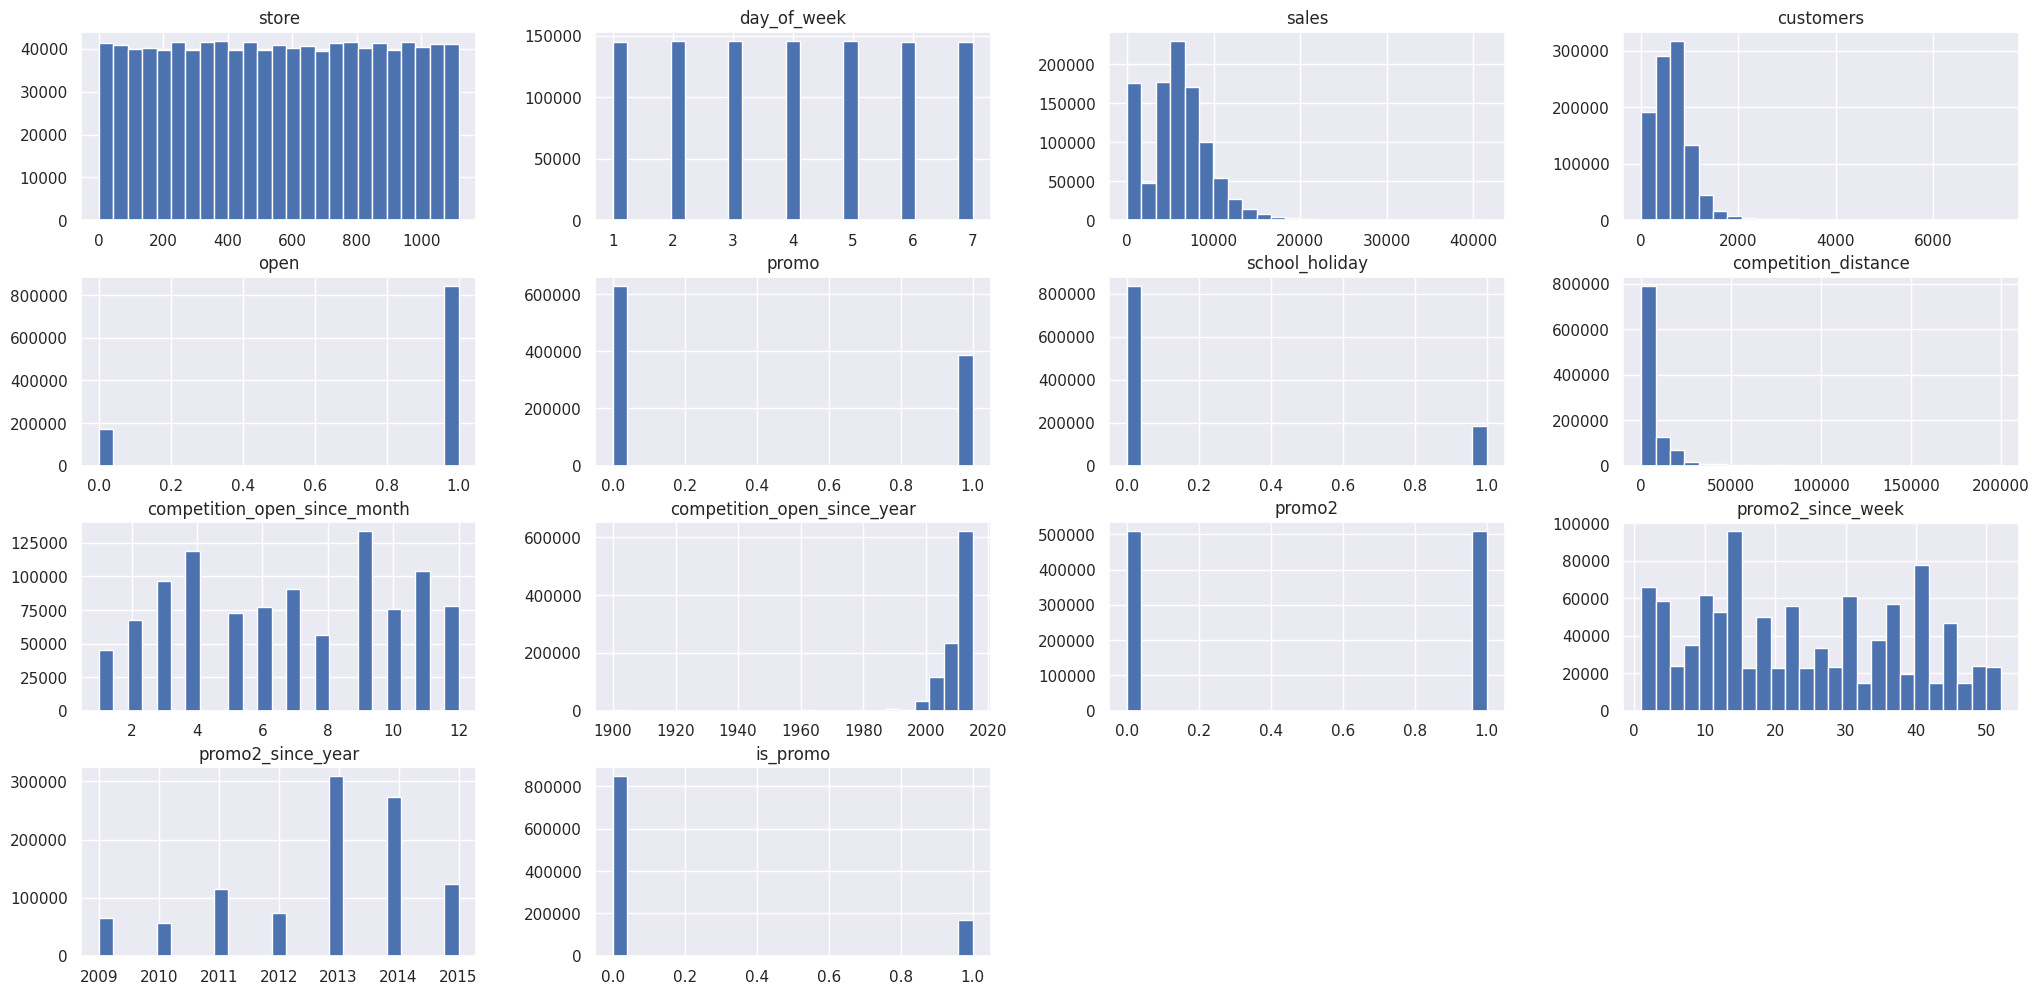

In [35]:
num_attributes.hist(bins = 25)

# 4.1.3 Categorical Variable

In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [ ]:
#verificando quanto que tem em cada variavel categorica
df4['state_holiday'].values_count(normalize = True)
df4['store_type'].values_count(normalize = True)
df4['assortment'].values_count(normalize = True)

<AxesSubplot: xlabel='sales', ylabel='Density'>

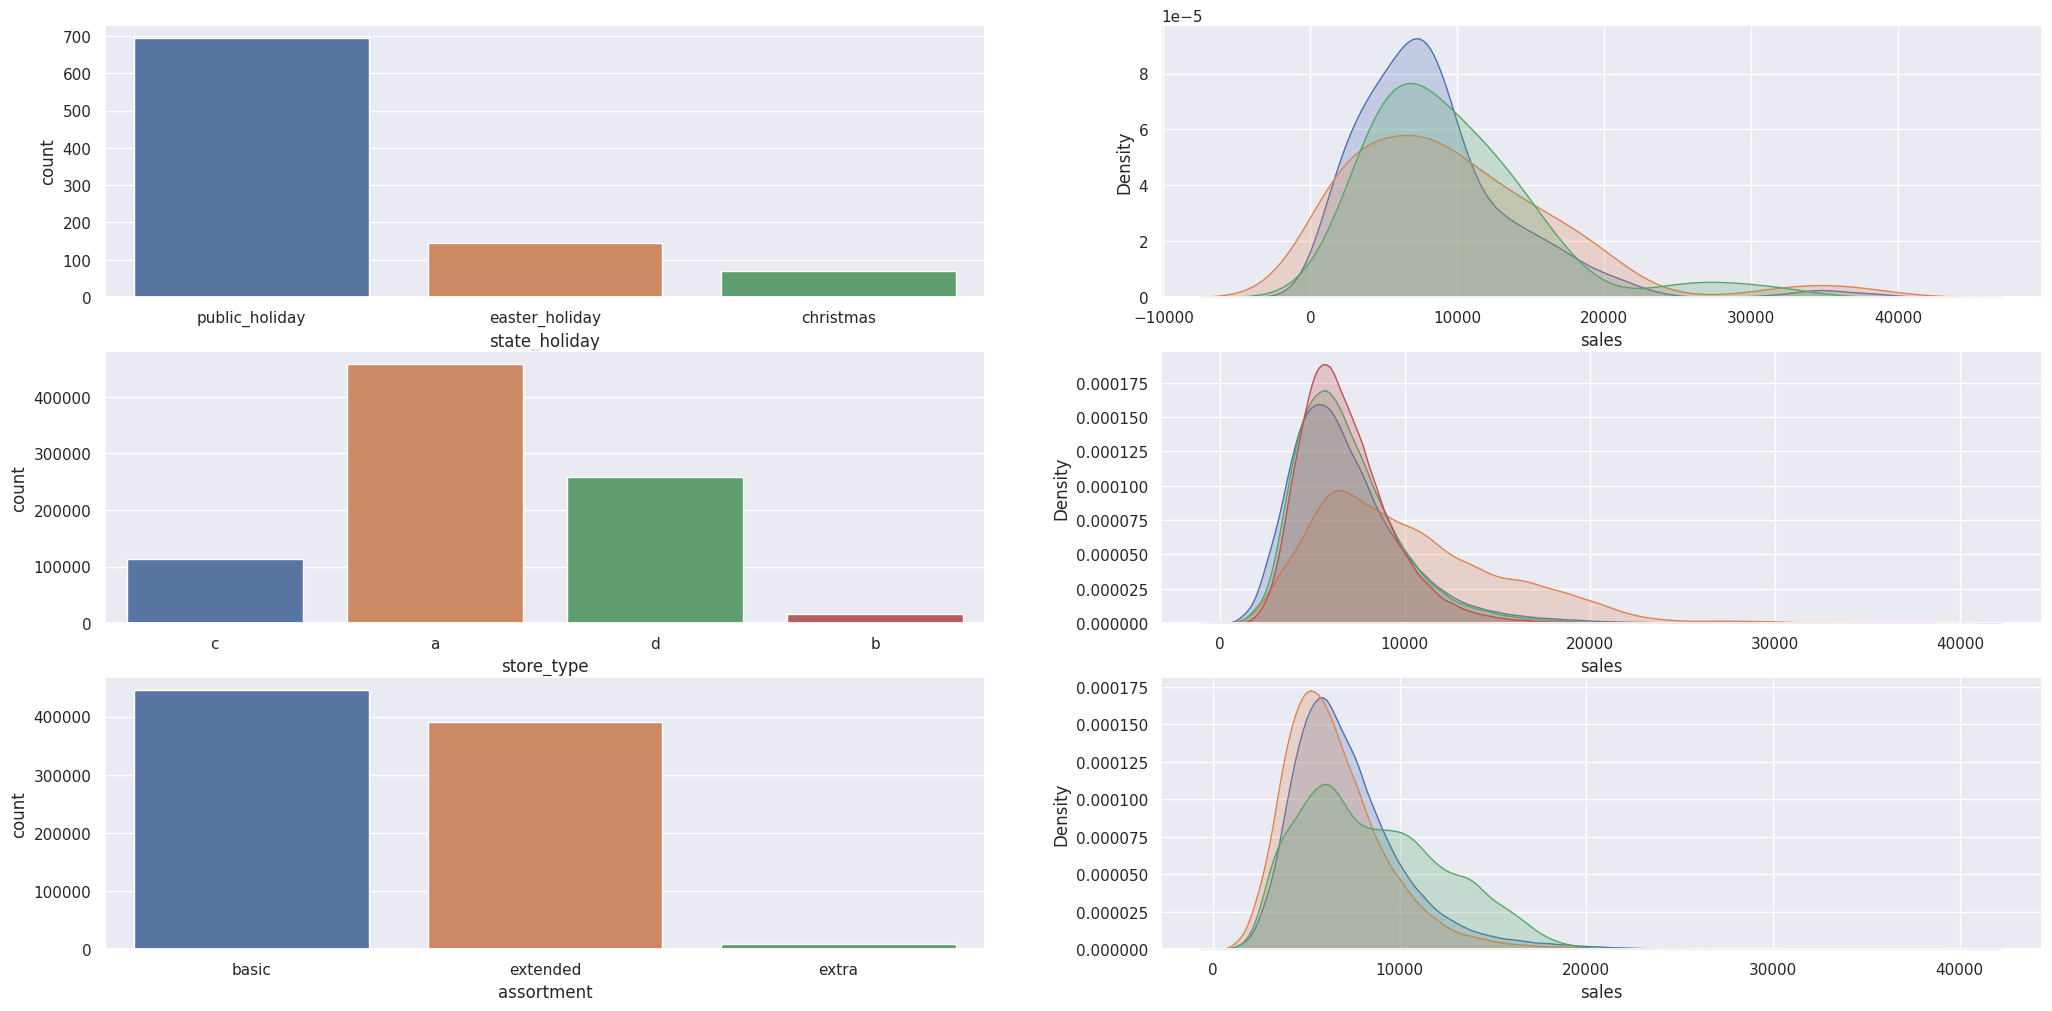

In [37]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(data = a , x = 'state_holiday')
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label = 'public_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label = 'easter_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label = 'christmas',shade = True)
#store_type
plt.subplot(3,2,3)
sns.countplot(data = df4,x = 'store_type')
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label = 'a',shade = True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label = 'b',shade = True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label = 'c',shade = True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label = 'd',shade = True)


#assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label = 'extended',shade = True)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label = 'basic',shade = True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label = 'extra',shade = True)



# 4.2 Análise Bivariada

# h1. Lojas com maior sortimento deveriam vender mais
**Falso** Lojas com MAIS SORTIMENTO VENDEM MENOS

<AxesSubplot: xlabel='year_week'>

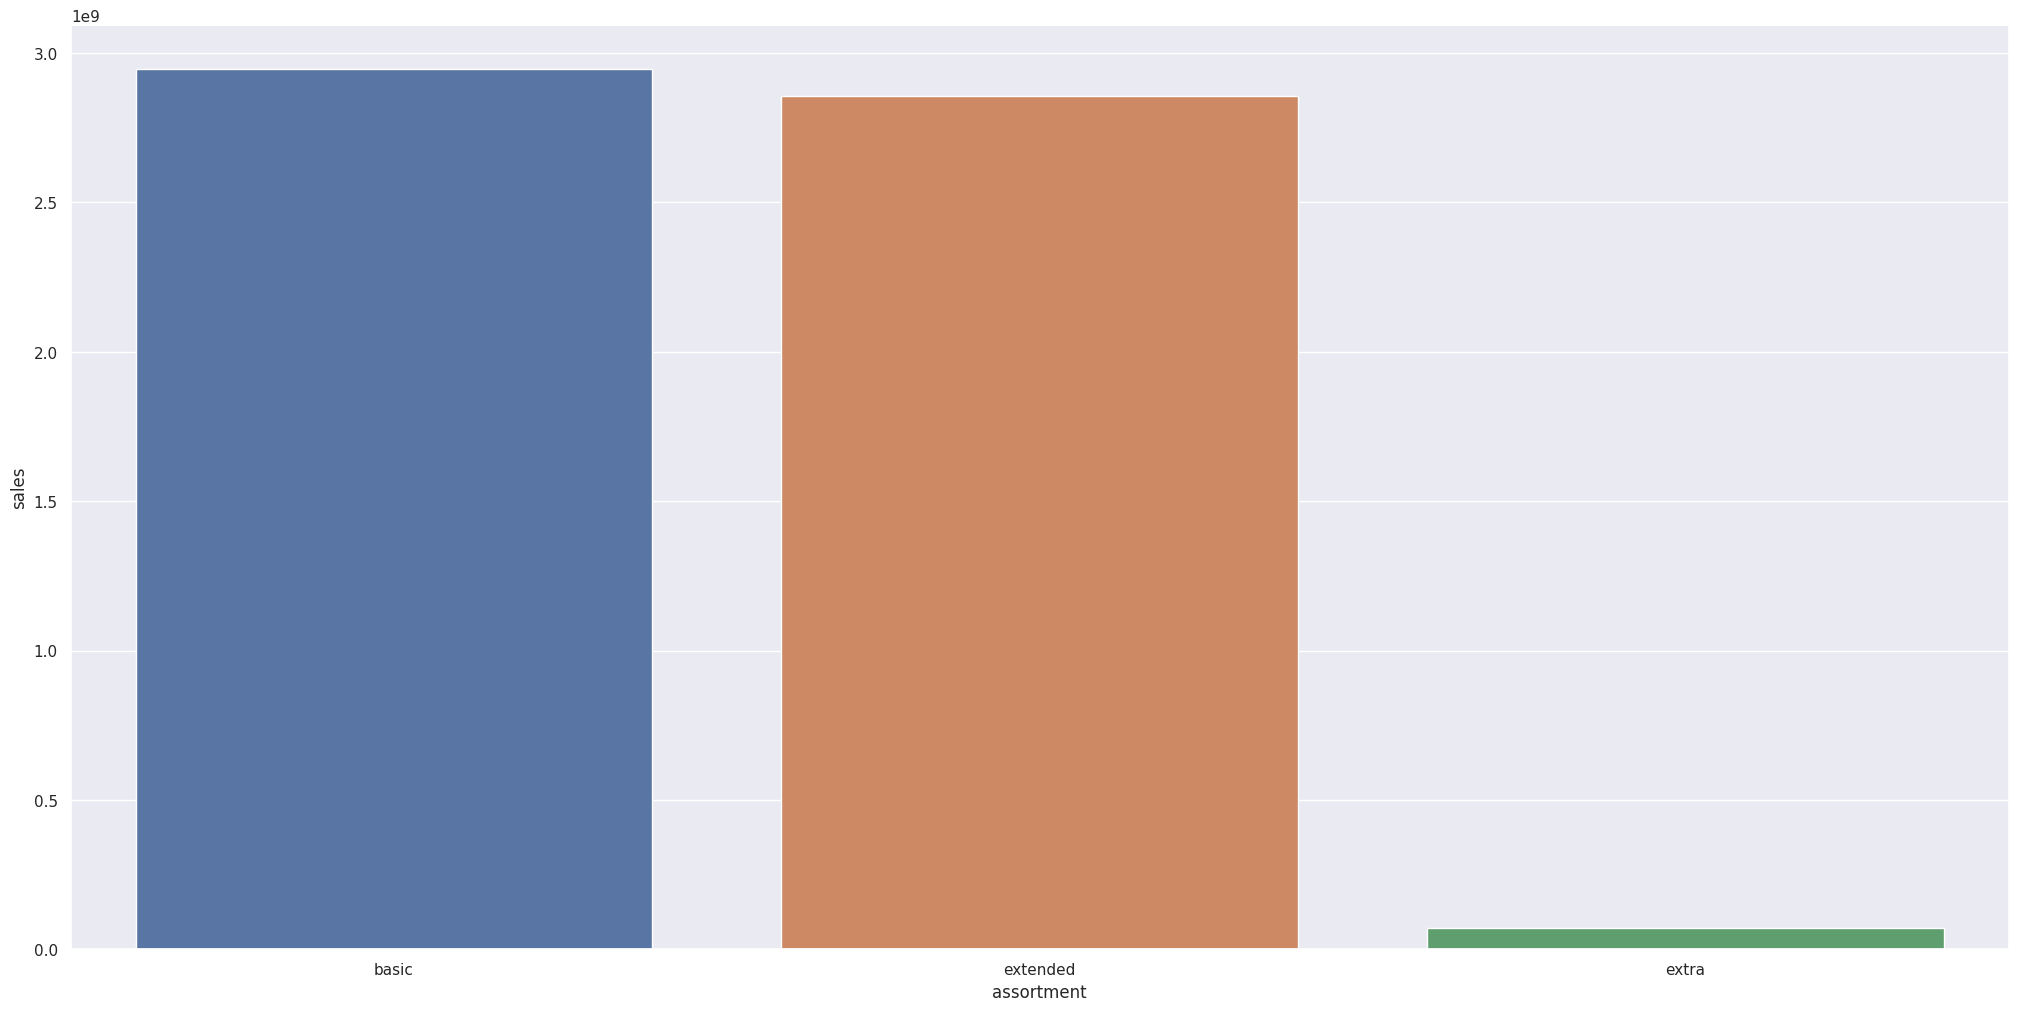

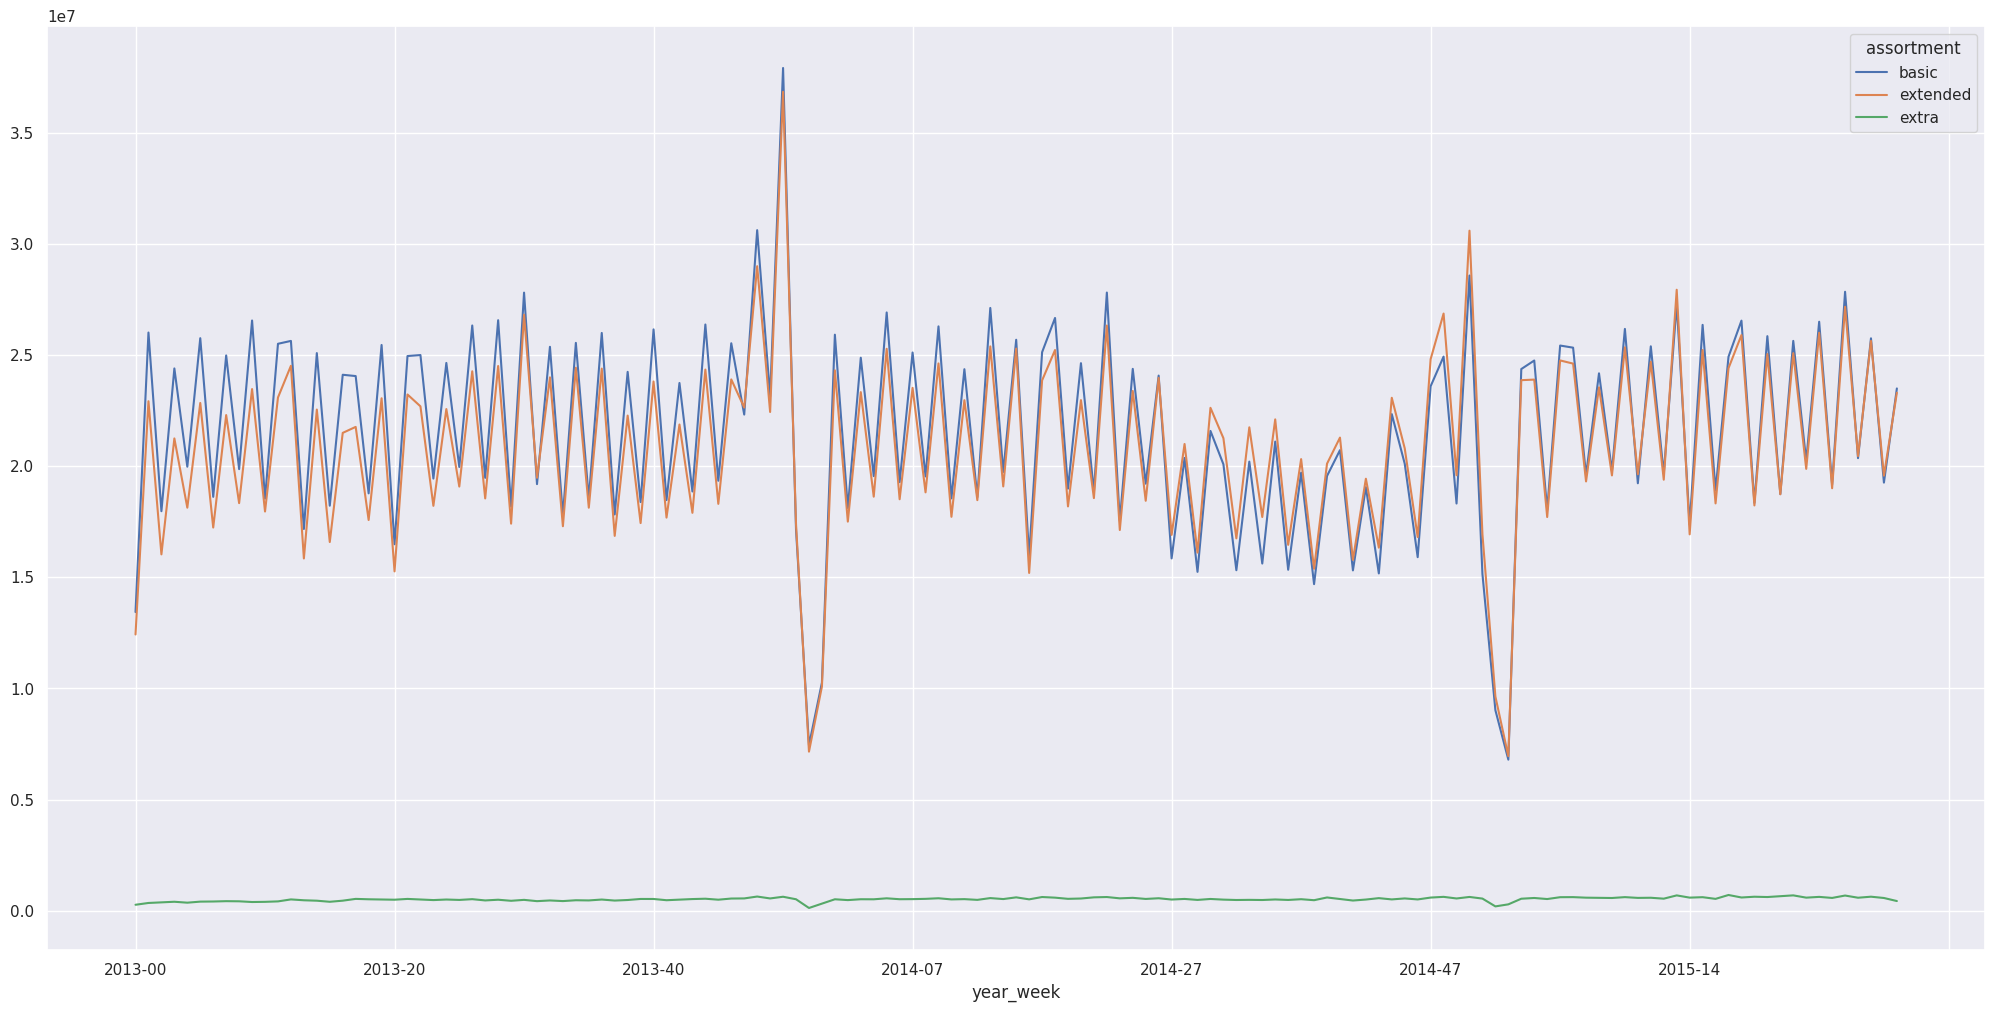

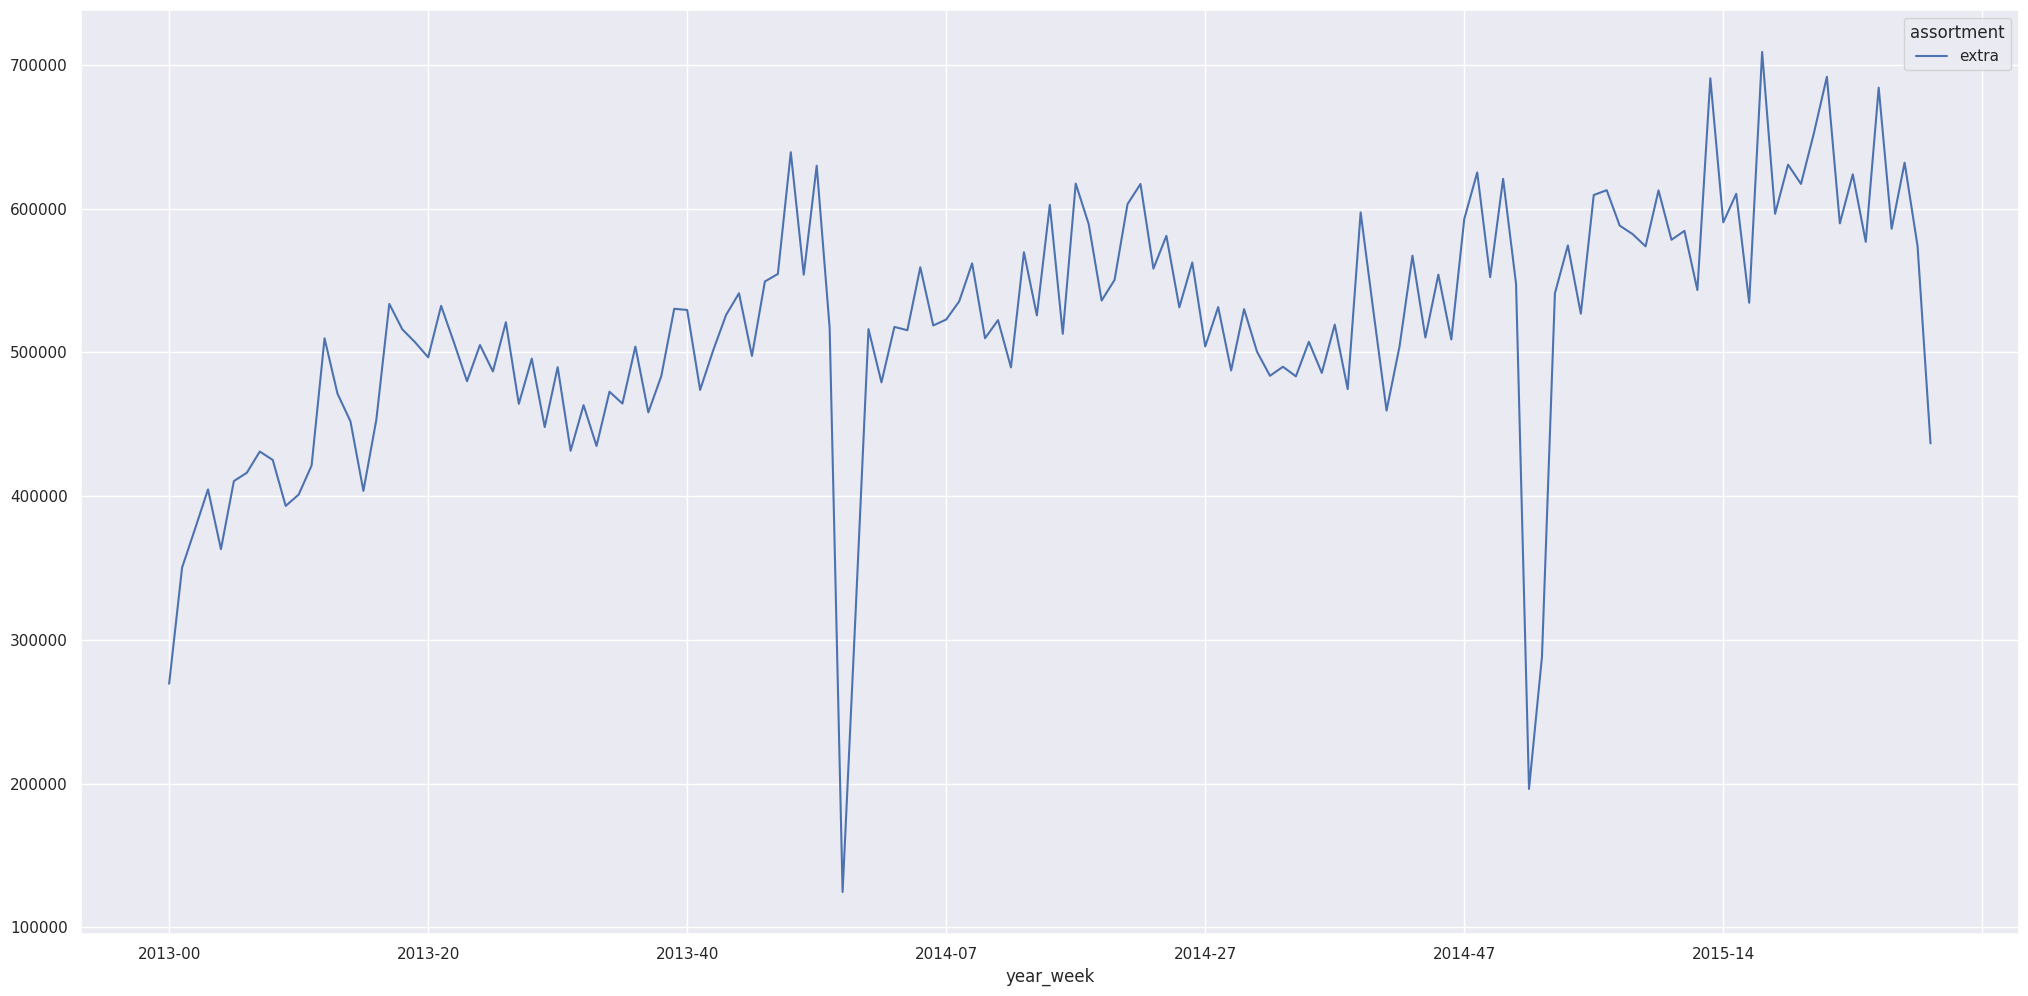

In [38]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x = 'assortment', y='sales', data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week',columns='assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment', values = 'sales').plot()

# h2. Lojas com competidores mais próximos deveriam vender menos
**Falsa**.Por média, vendem na mesma faixa de números.


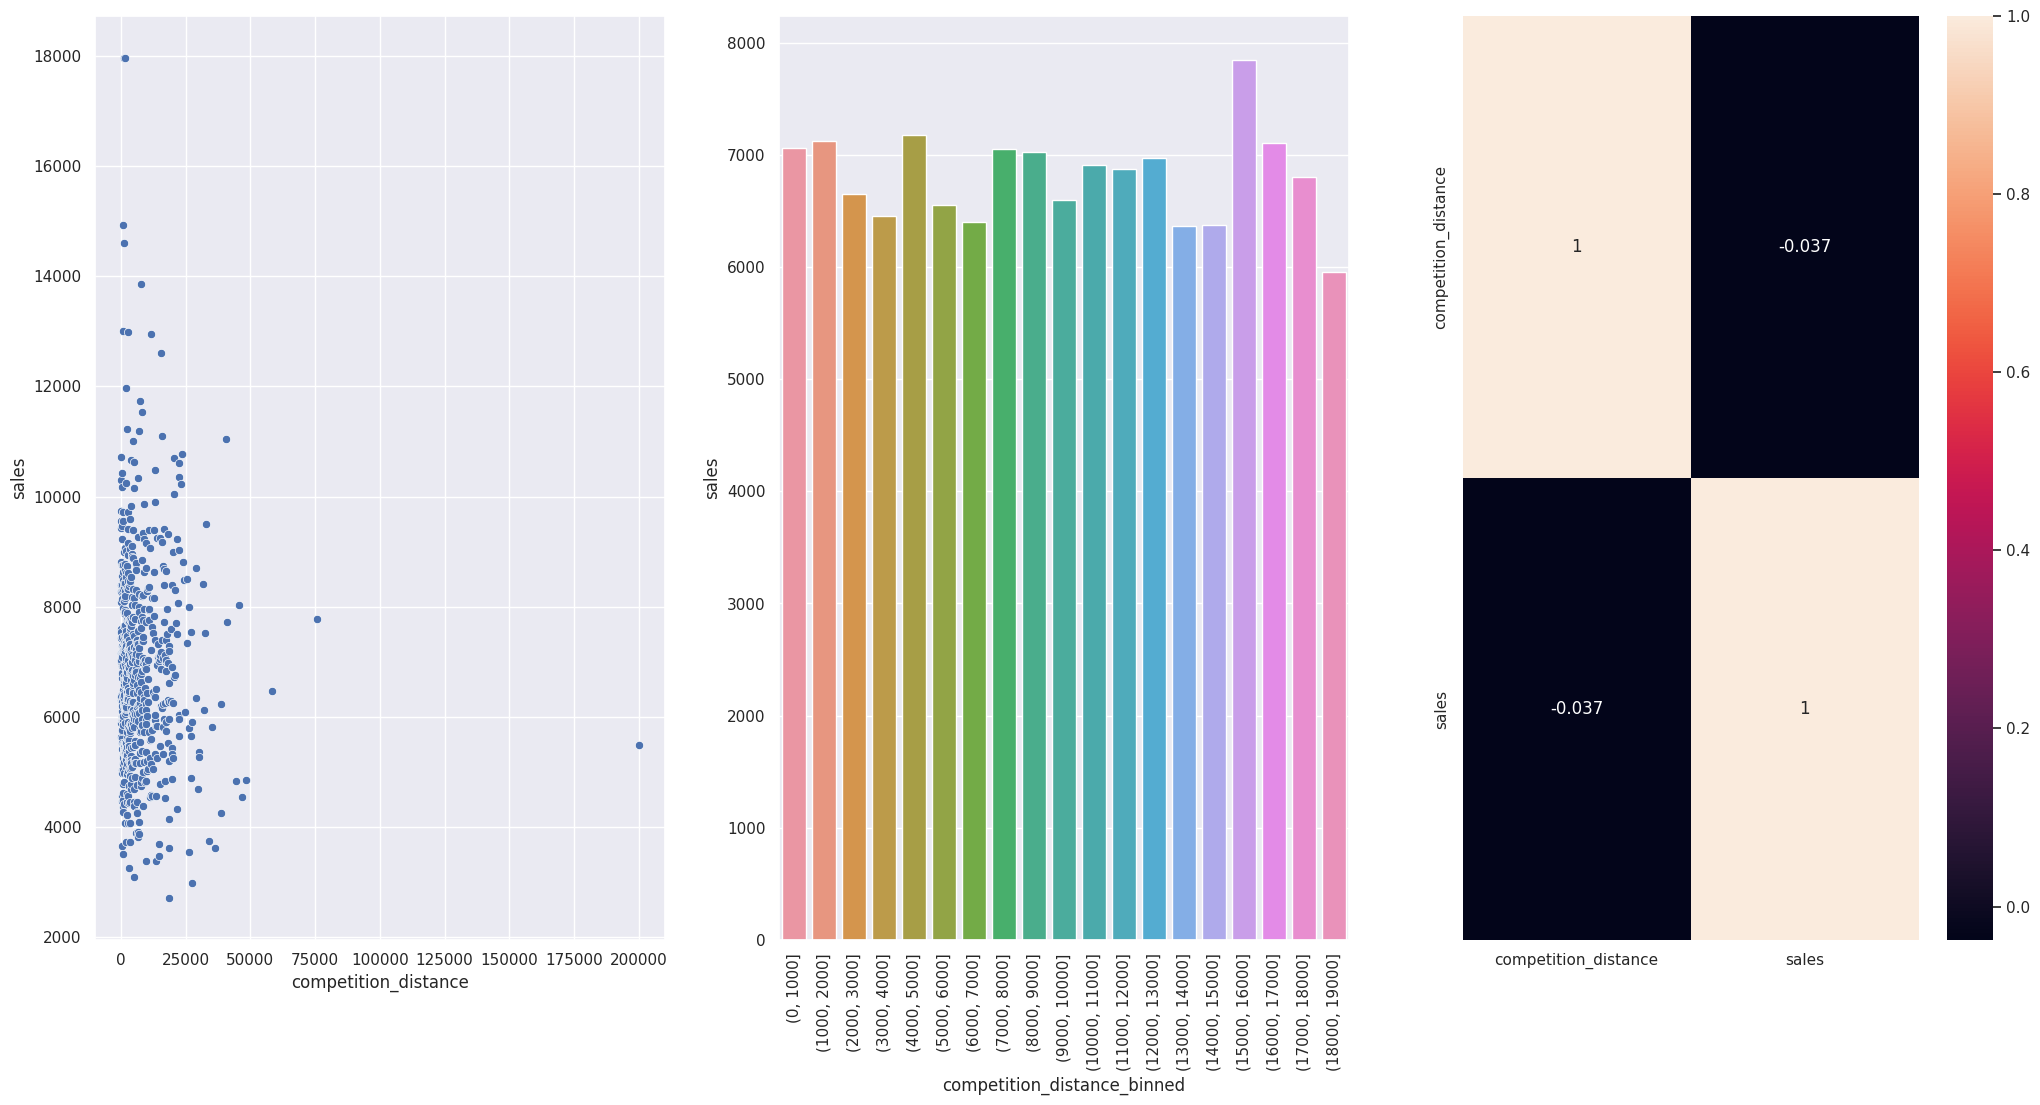

In [39]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1);
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


# h3. Lojas com competidores a mais tempo deveriam vender mais
**Falso** Lojas com competidores a mais tempo VENDEM MENOS

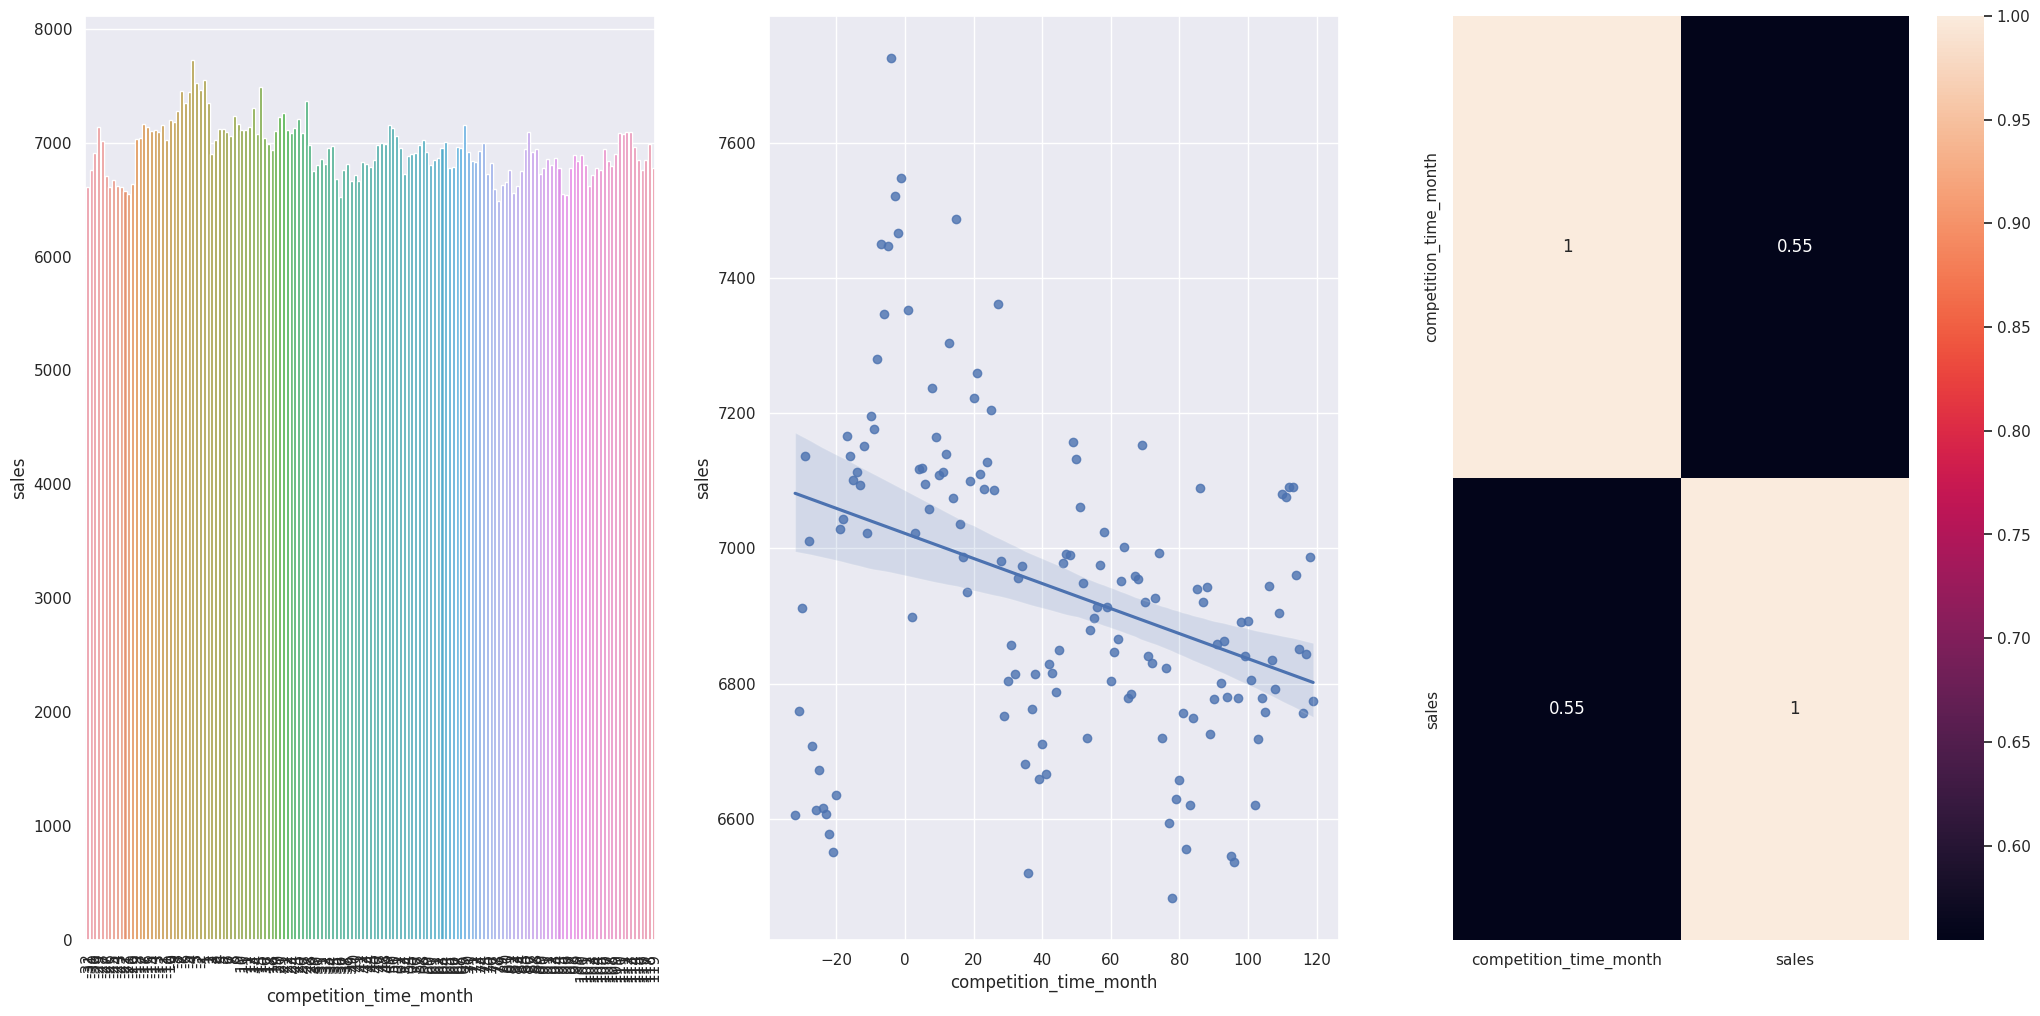

In [40]:
#aux1 = df4[['competition_open_since_month','sales']].groupby('competition_open_since_month').sum().reset_index()
#sns.barplot(x = 'competition_open_since_month',y = 'sales',data = aux1);
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <  120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month',y = 'sales',data = aux2);
plt.xticks(rotation = 90);
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y = 'sales',data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

# H4 Lojas com promoções mais ativas por mais tempo nos produtos deveriam vender mais
**Falsa** As lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção


In [41]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


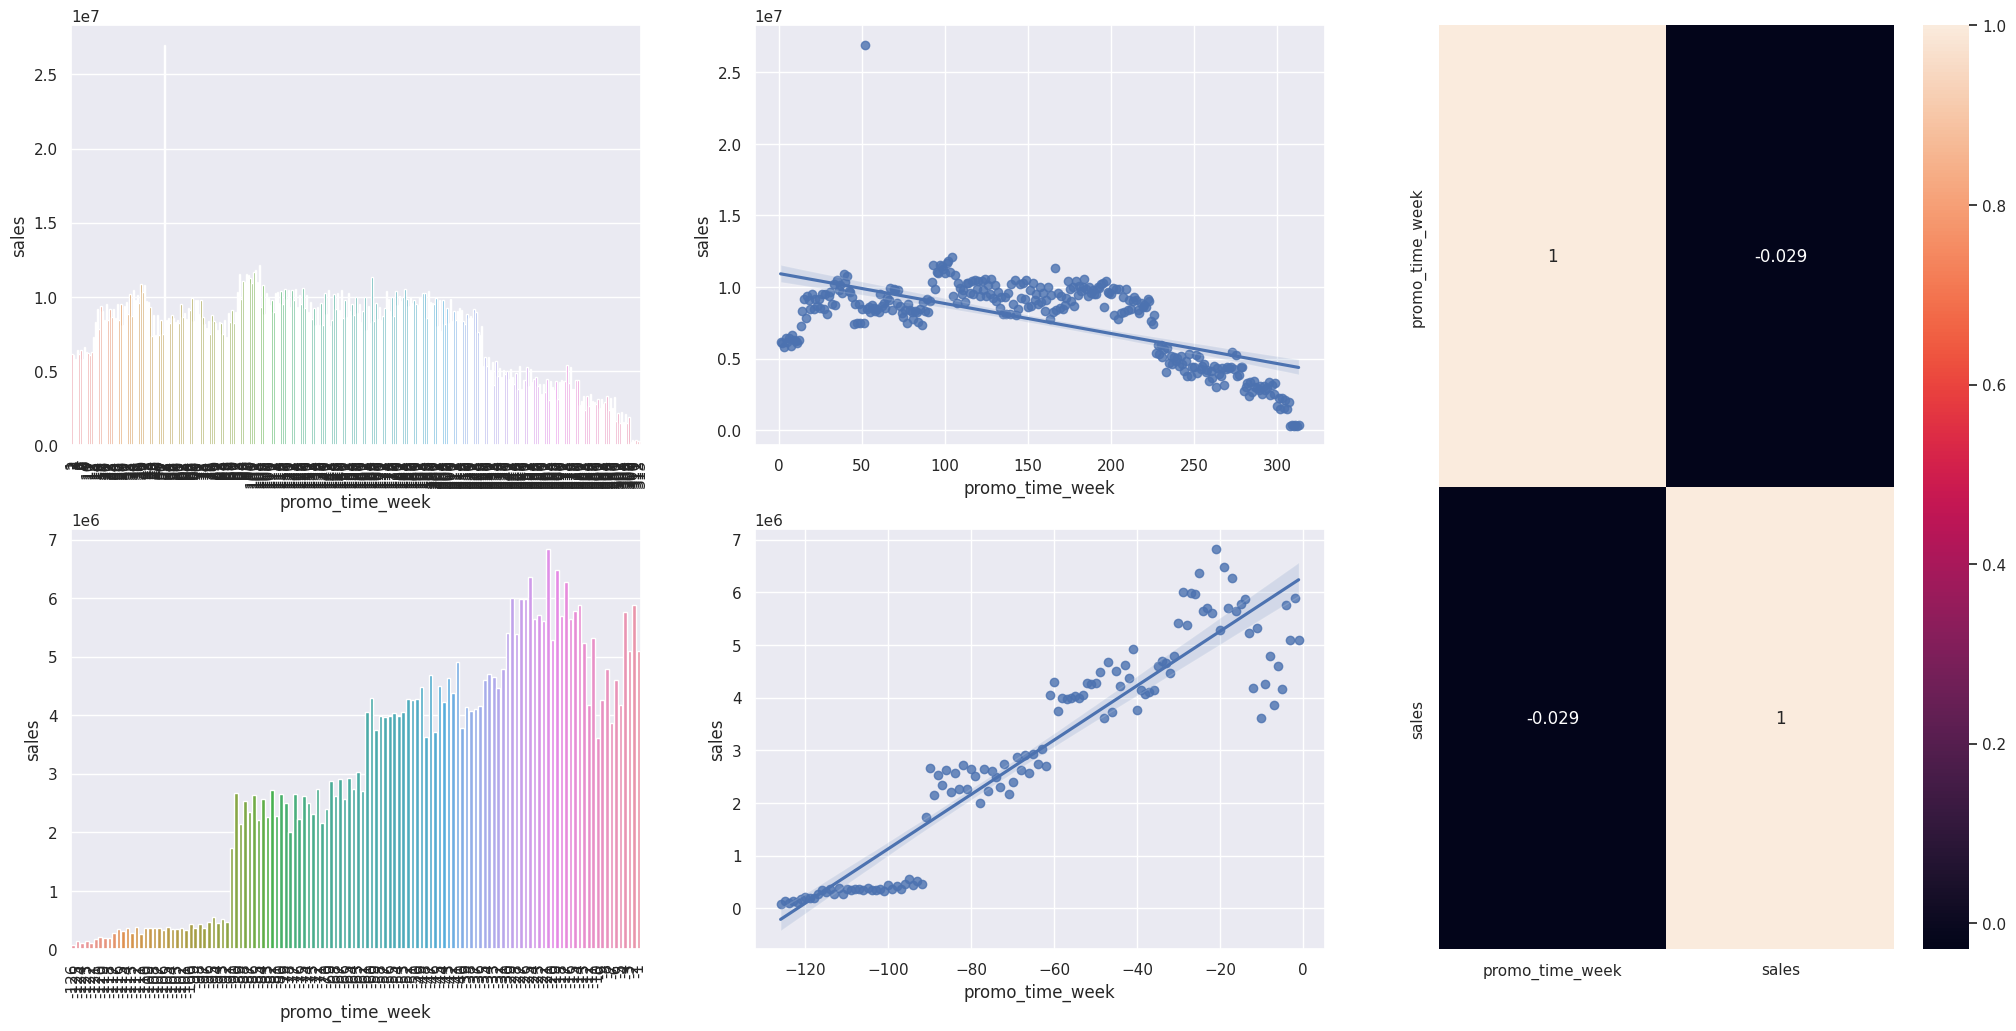

In [42]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] #promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[: , 2])
sns.heatmap(aux1.corr(method = 'pearson'),annot = True);

# H5 Lojas com mais promoções consecutivas deveriam vender mais
**Falso** Lojas com promoções consecutivas vendem menos

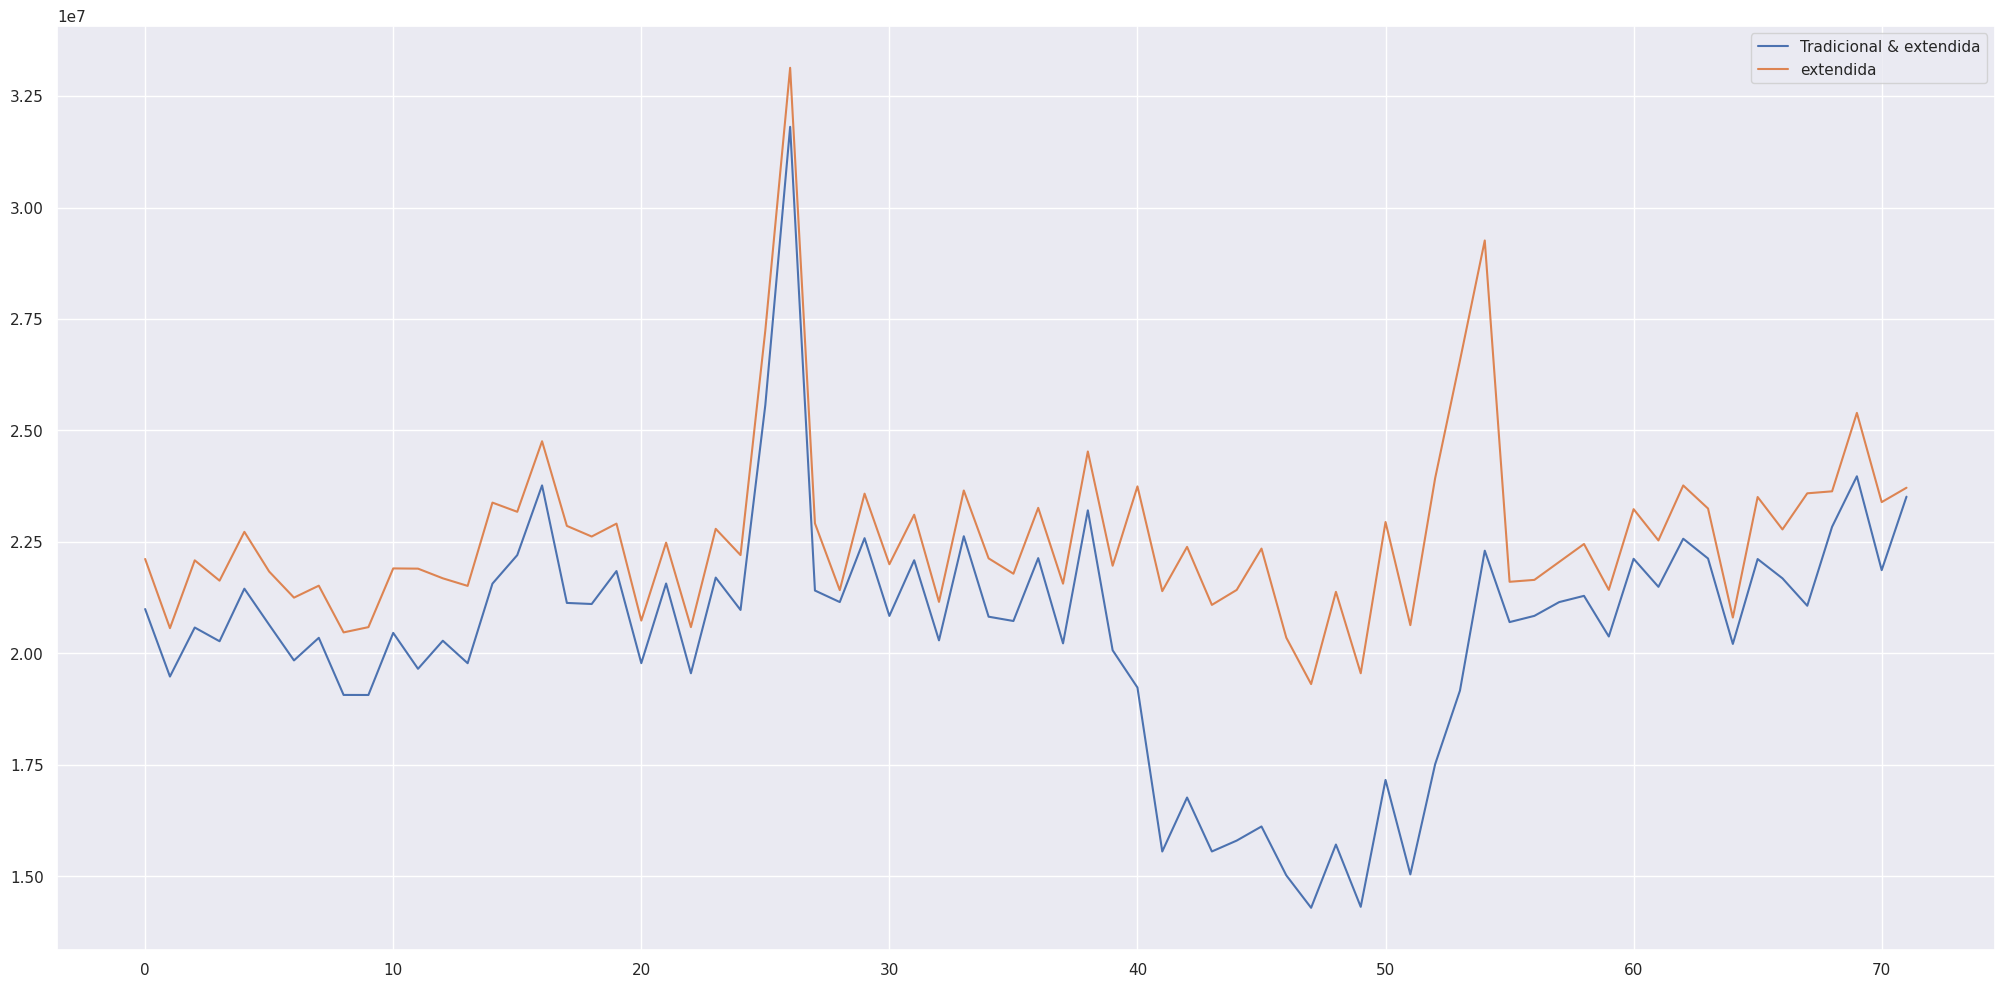

In [43]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()
aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional & extendida','extendida']);

# h6. Lojas abertas durante o feriado de natal deveriam vender mais
**Verdadeiro** Lojas abertas durante o natal vendem mais que os dias regulares

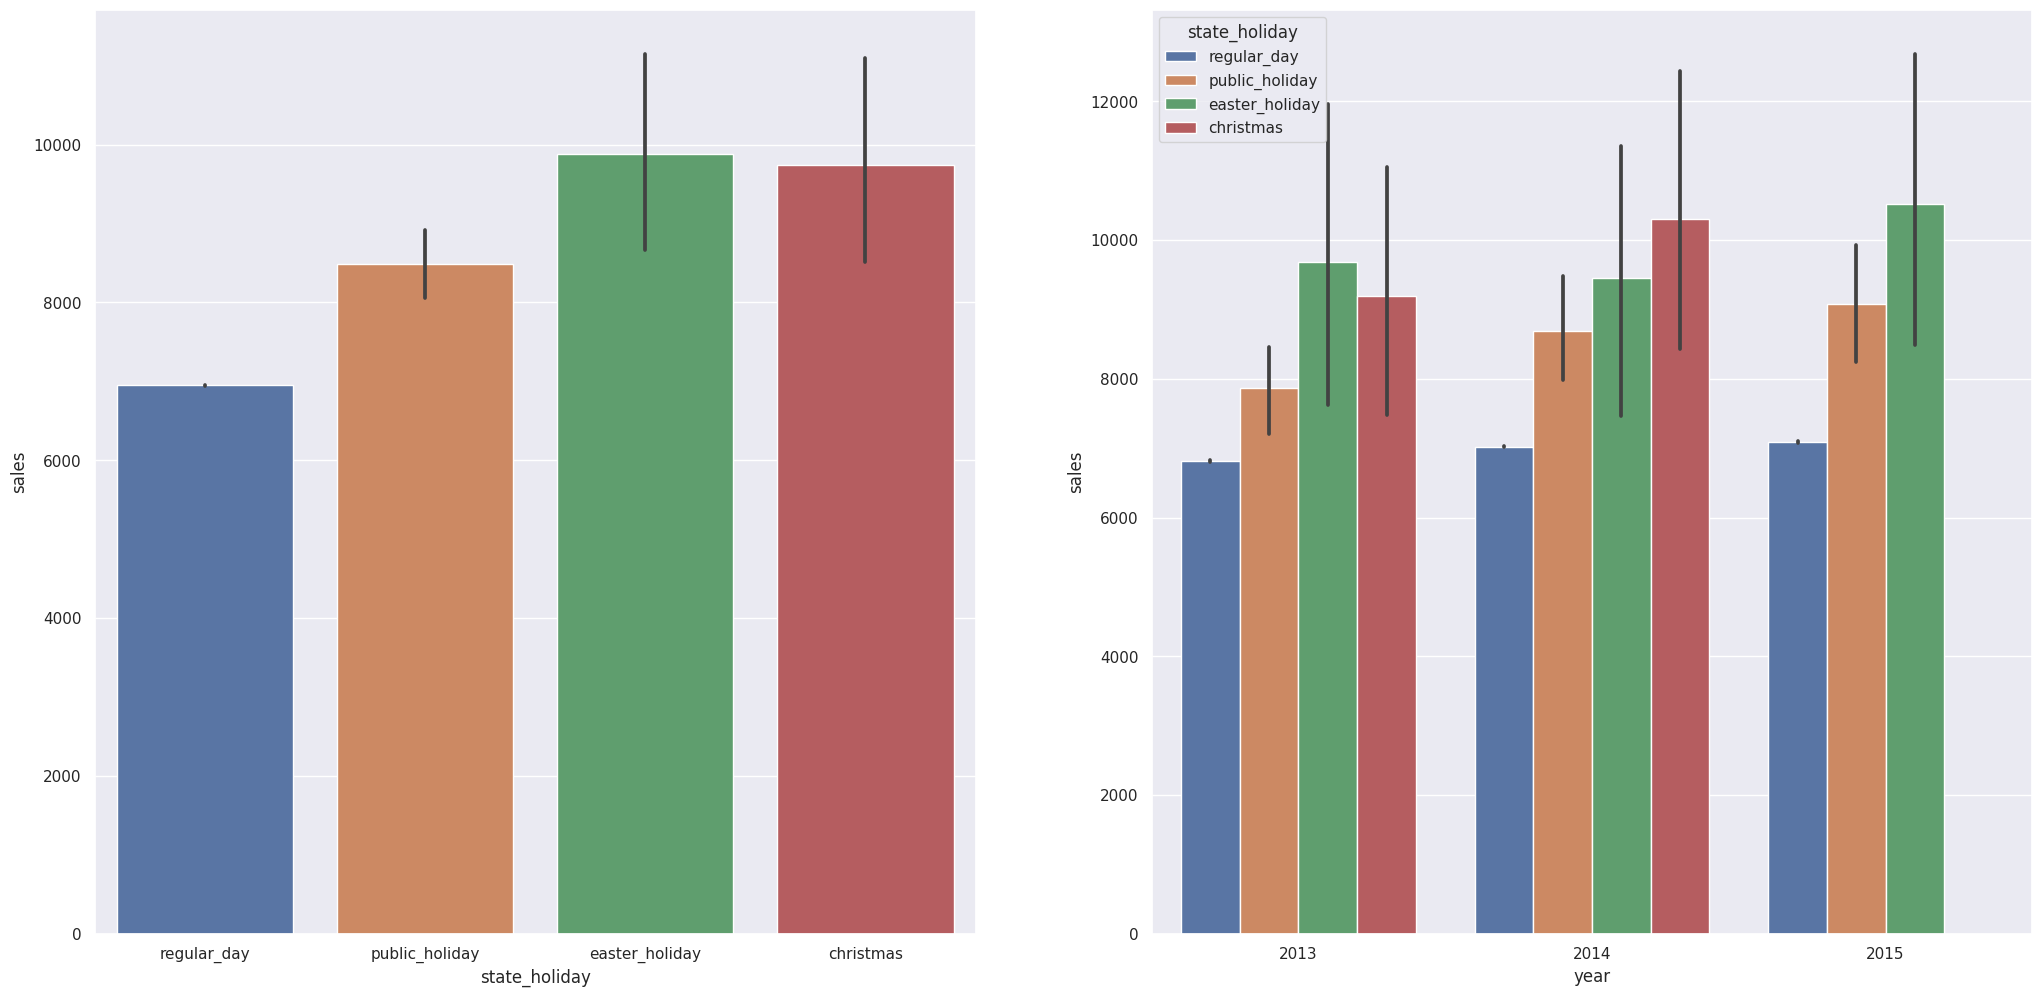

In [44]:

plt.subplot(1,2,1)
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday',y='sales', data = df4);

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday','sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x = 'year',y='sales',hue = 'state_holiday', data = df4);

# h7. Lojas deveriam vender mais ao longo dos anos
**Falso** Nos dois anos COMPLETOS abrangidos pelo dataset, as vendas diminuíram

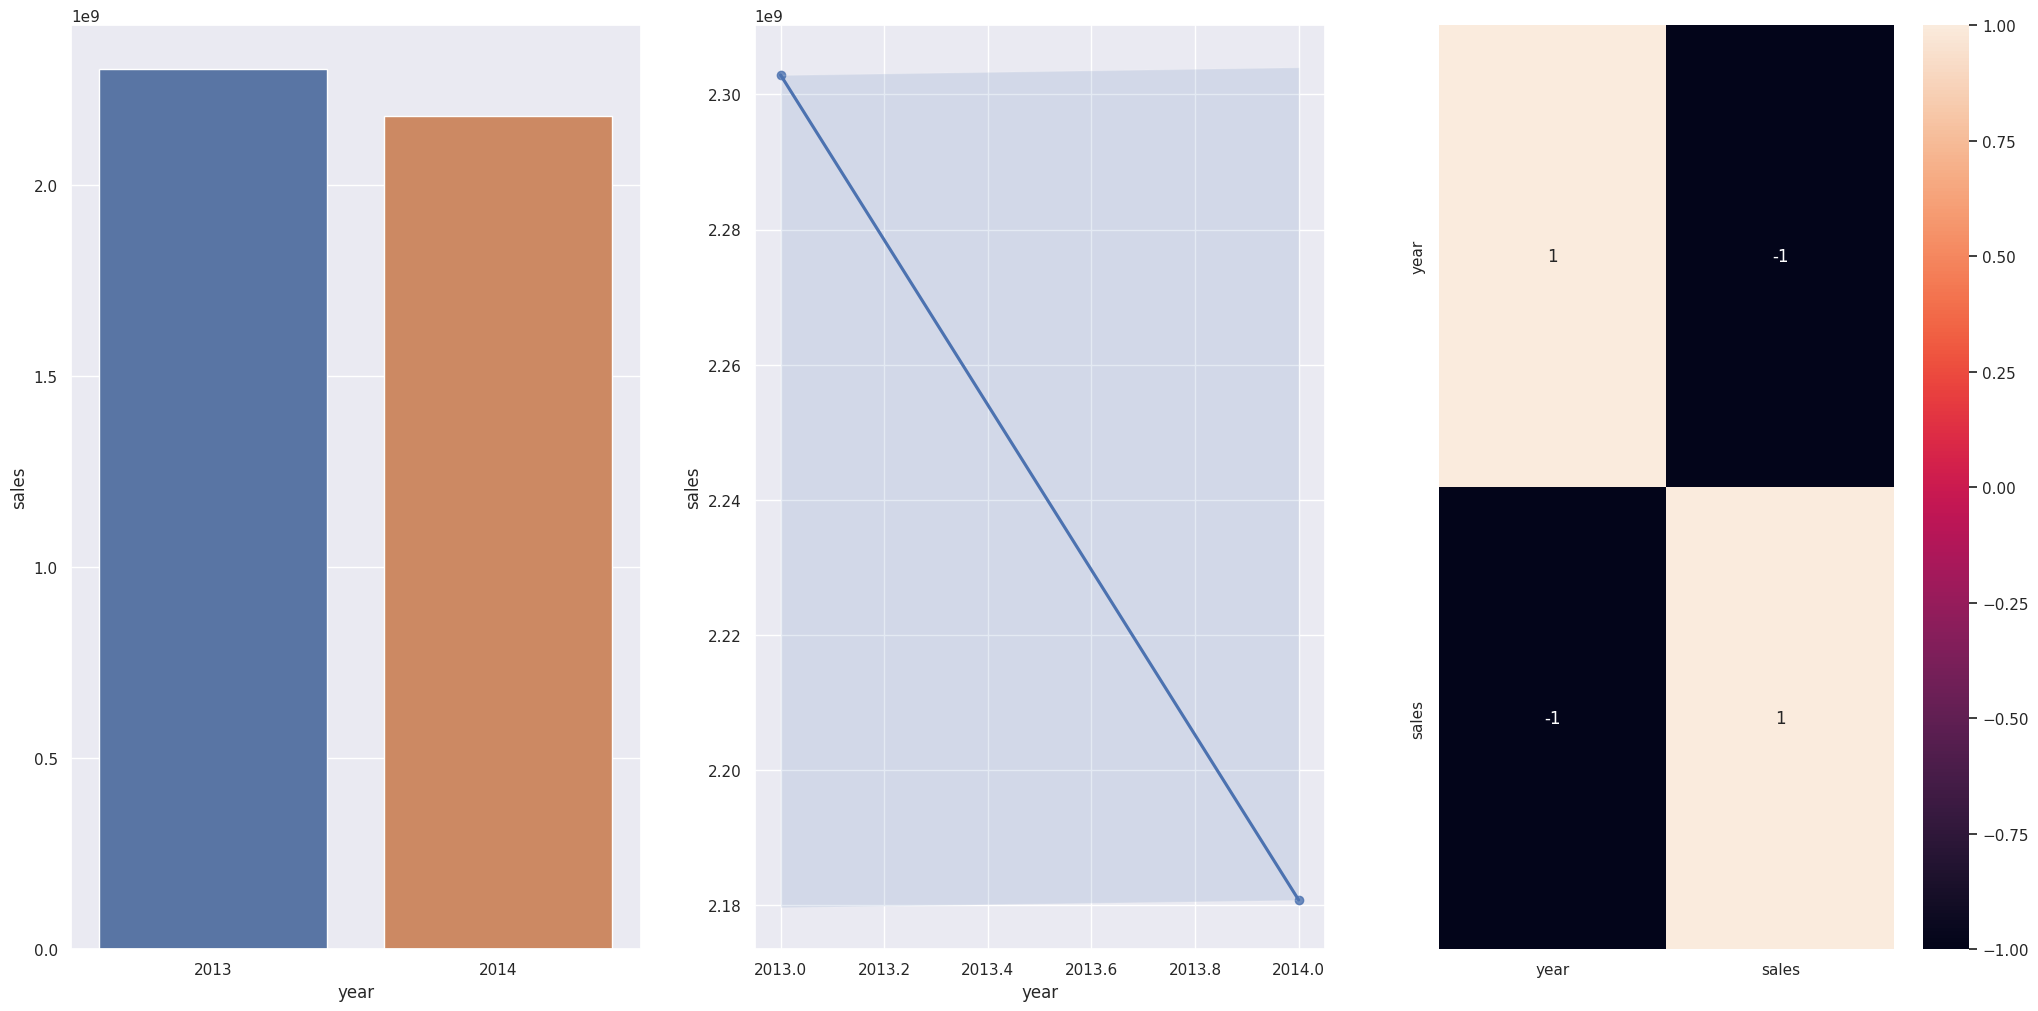

In [45]:
a = df4[df4['year'] != 2015 ]
aux1 = a[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h8 Lojas deveriam vender mais no segundo semestre do ano
**Verdadeiro** Lojas vendem mais no segundo semestre

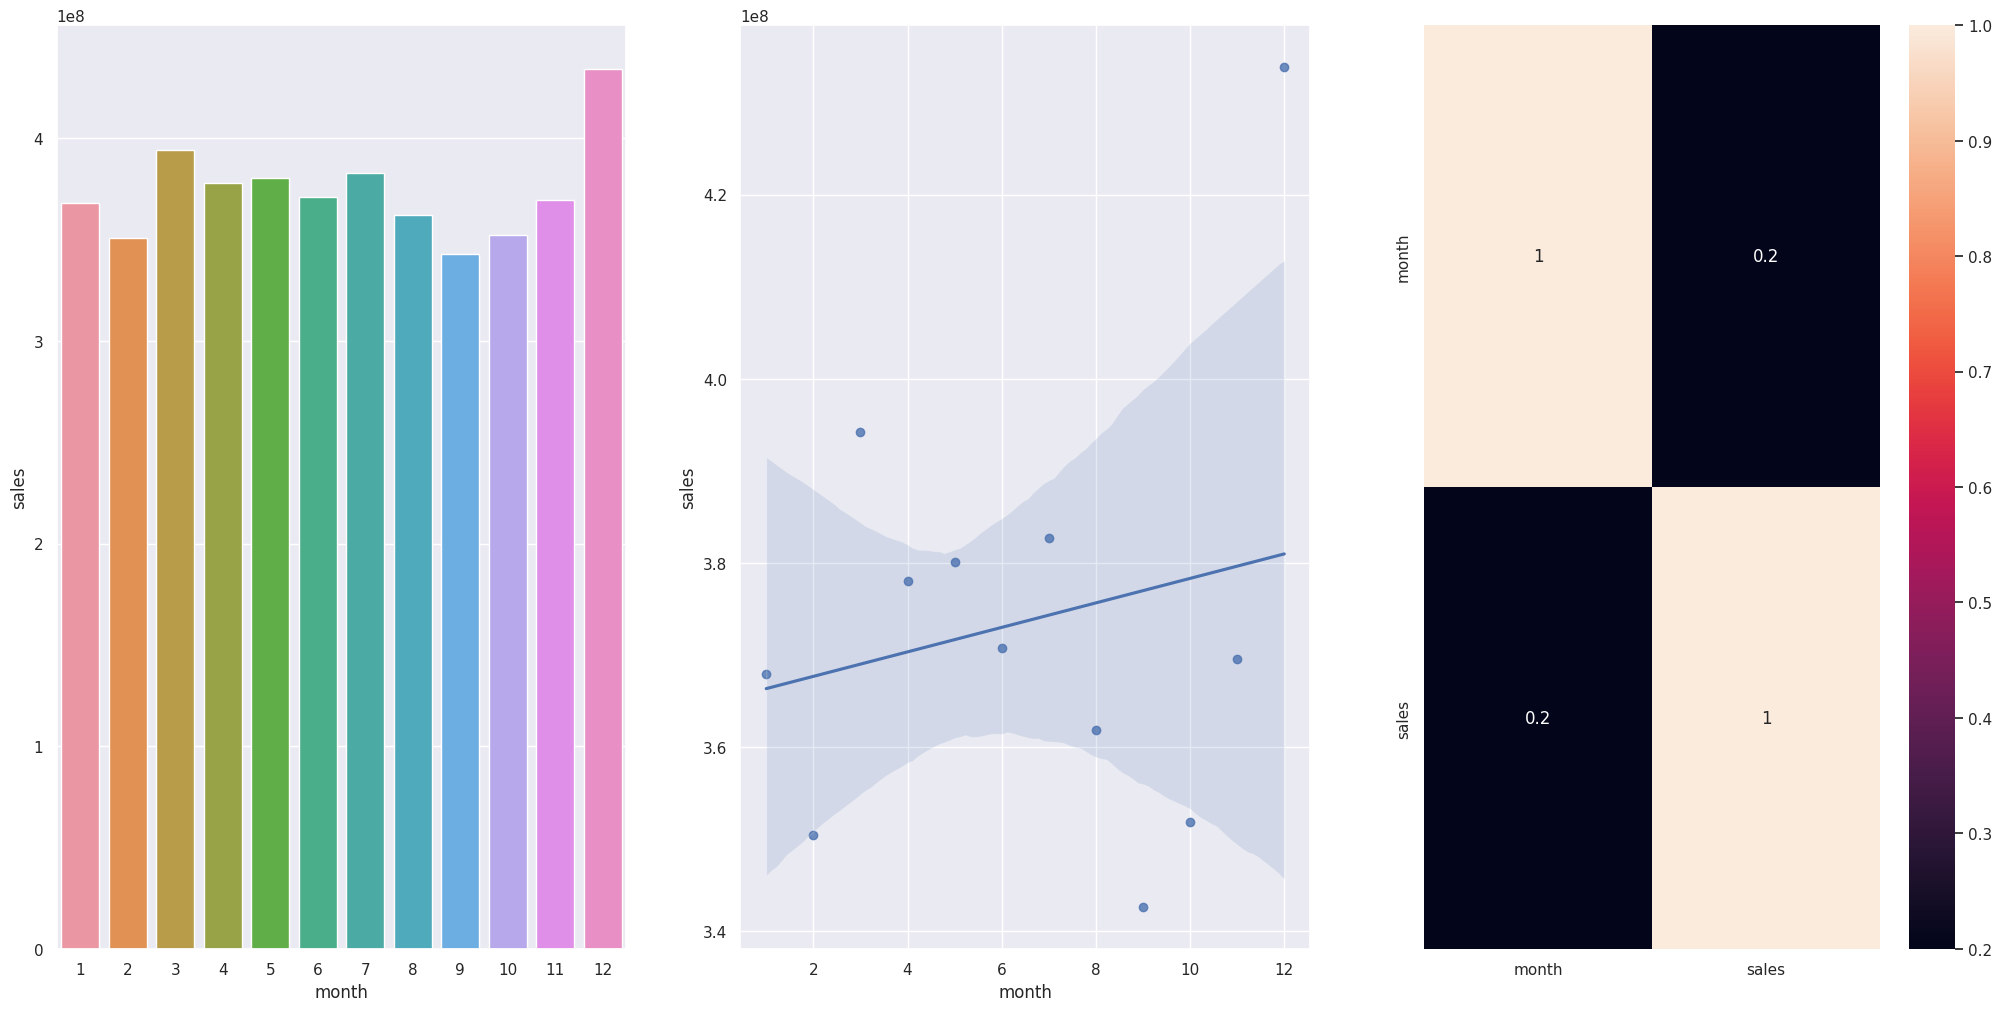

In [46]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h9 Lojas deveriam vender mais depois do dia 10 do mês
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

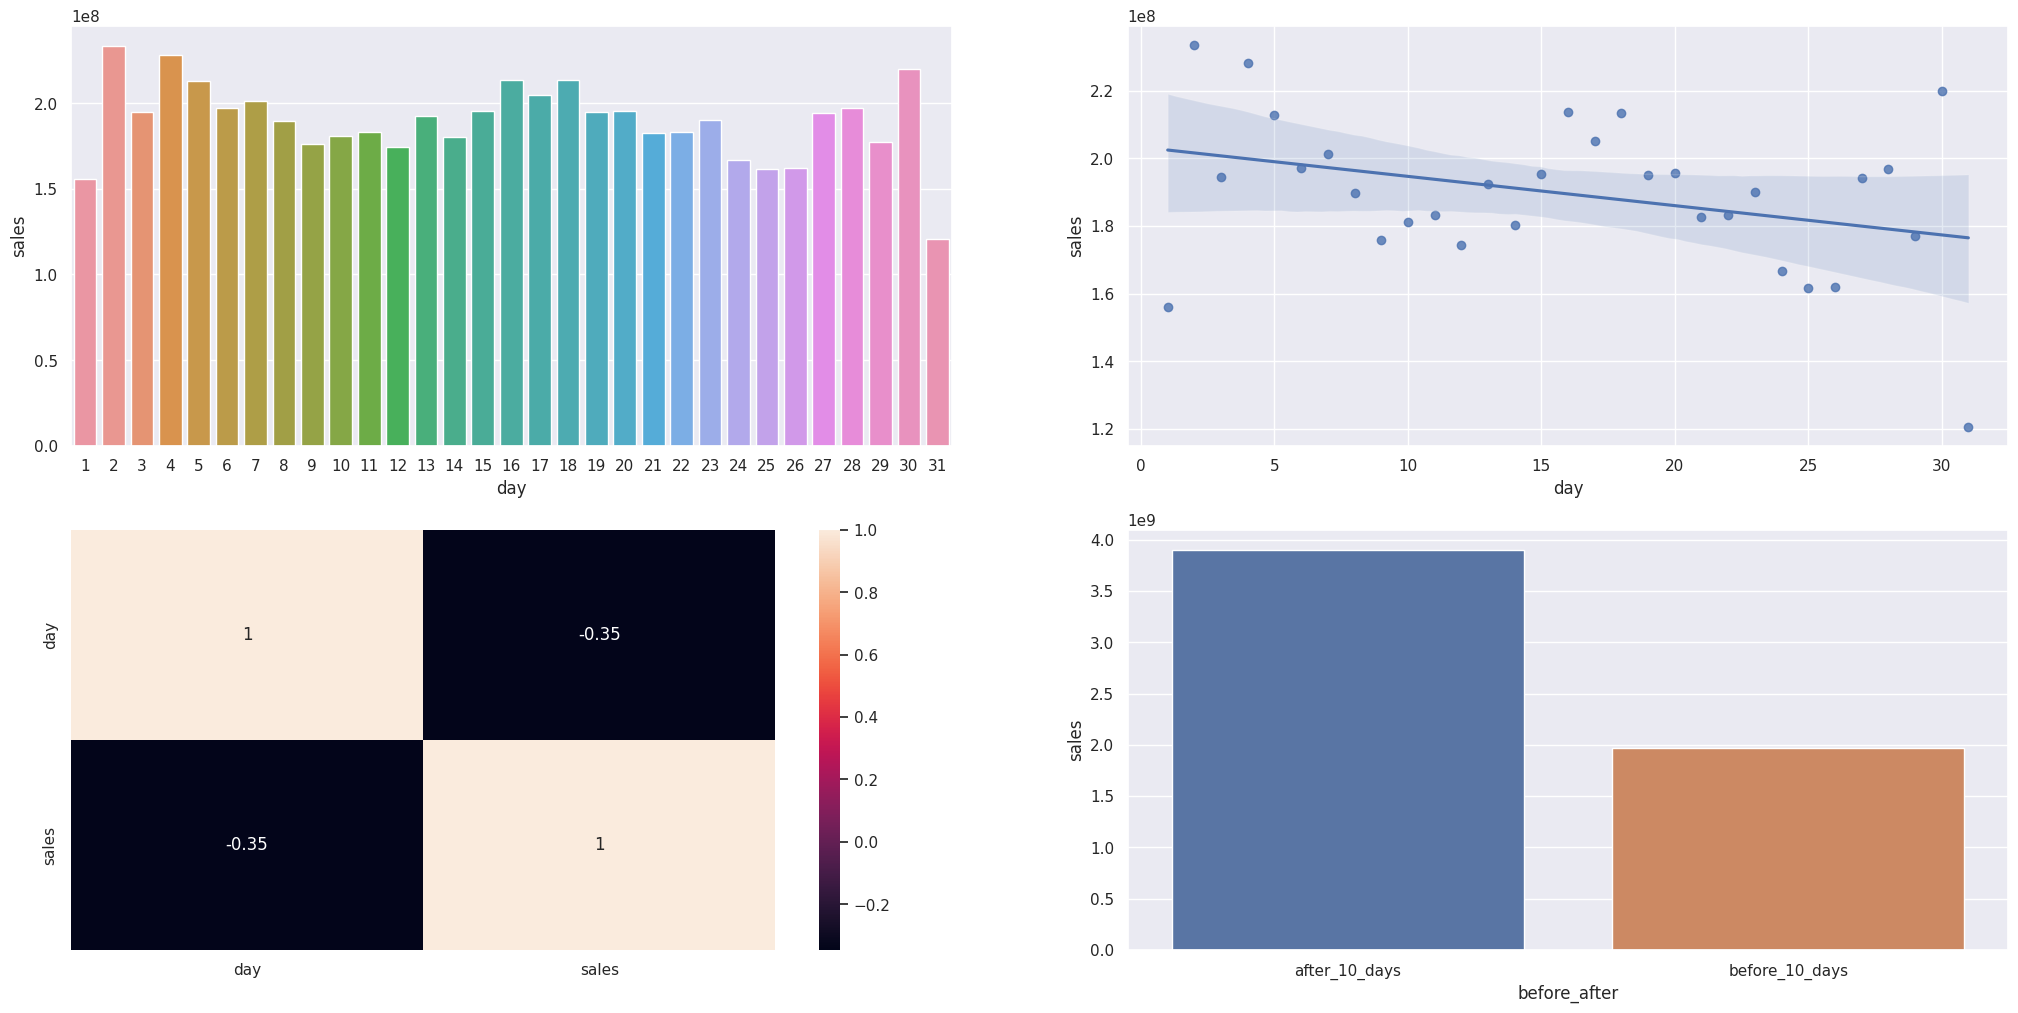

In [47]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

# h10. Lojas deveriam vender menos aos finais de semana

**VERDADEIRA** Lojas vendem menos nos final de semana

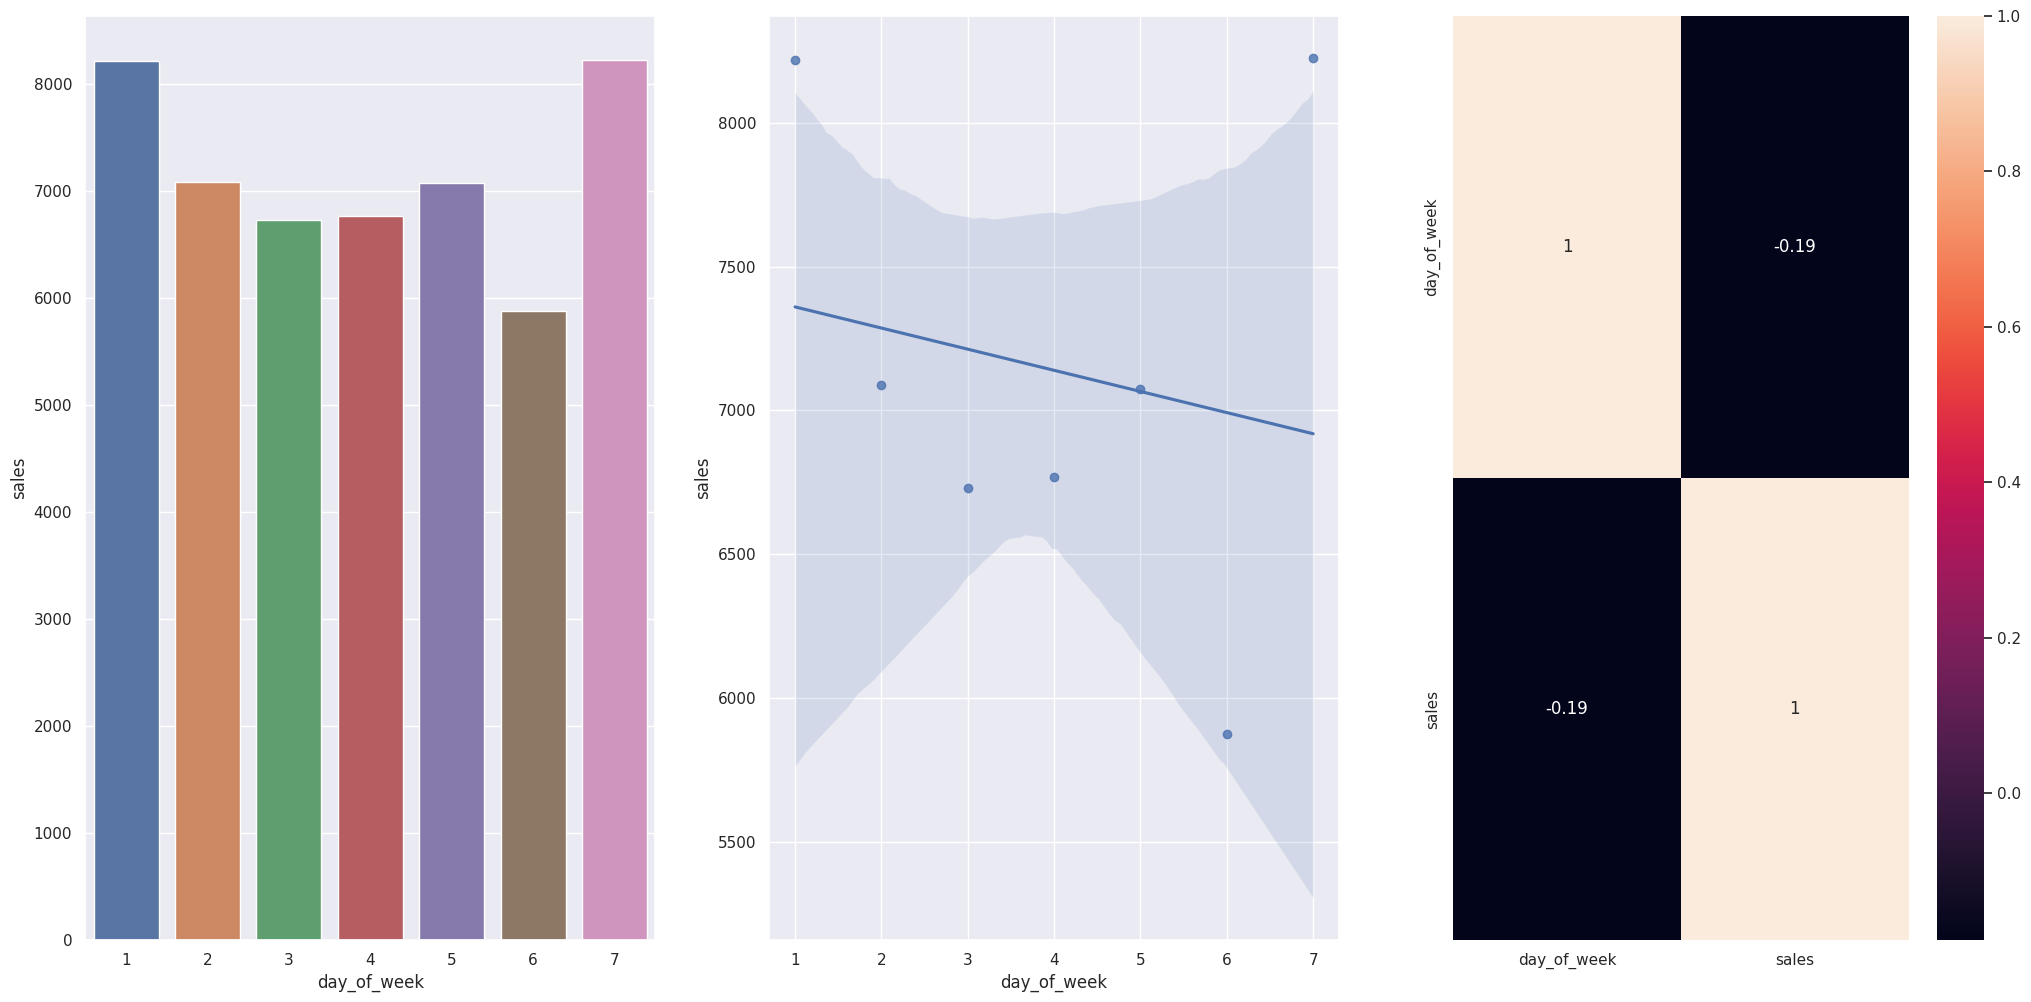

In [48]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# h11. Lojas deveriam vender menos durante feriados escolares
**Falso** Lojas vendem mais durante os feriados escolares.

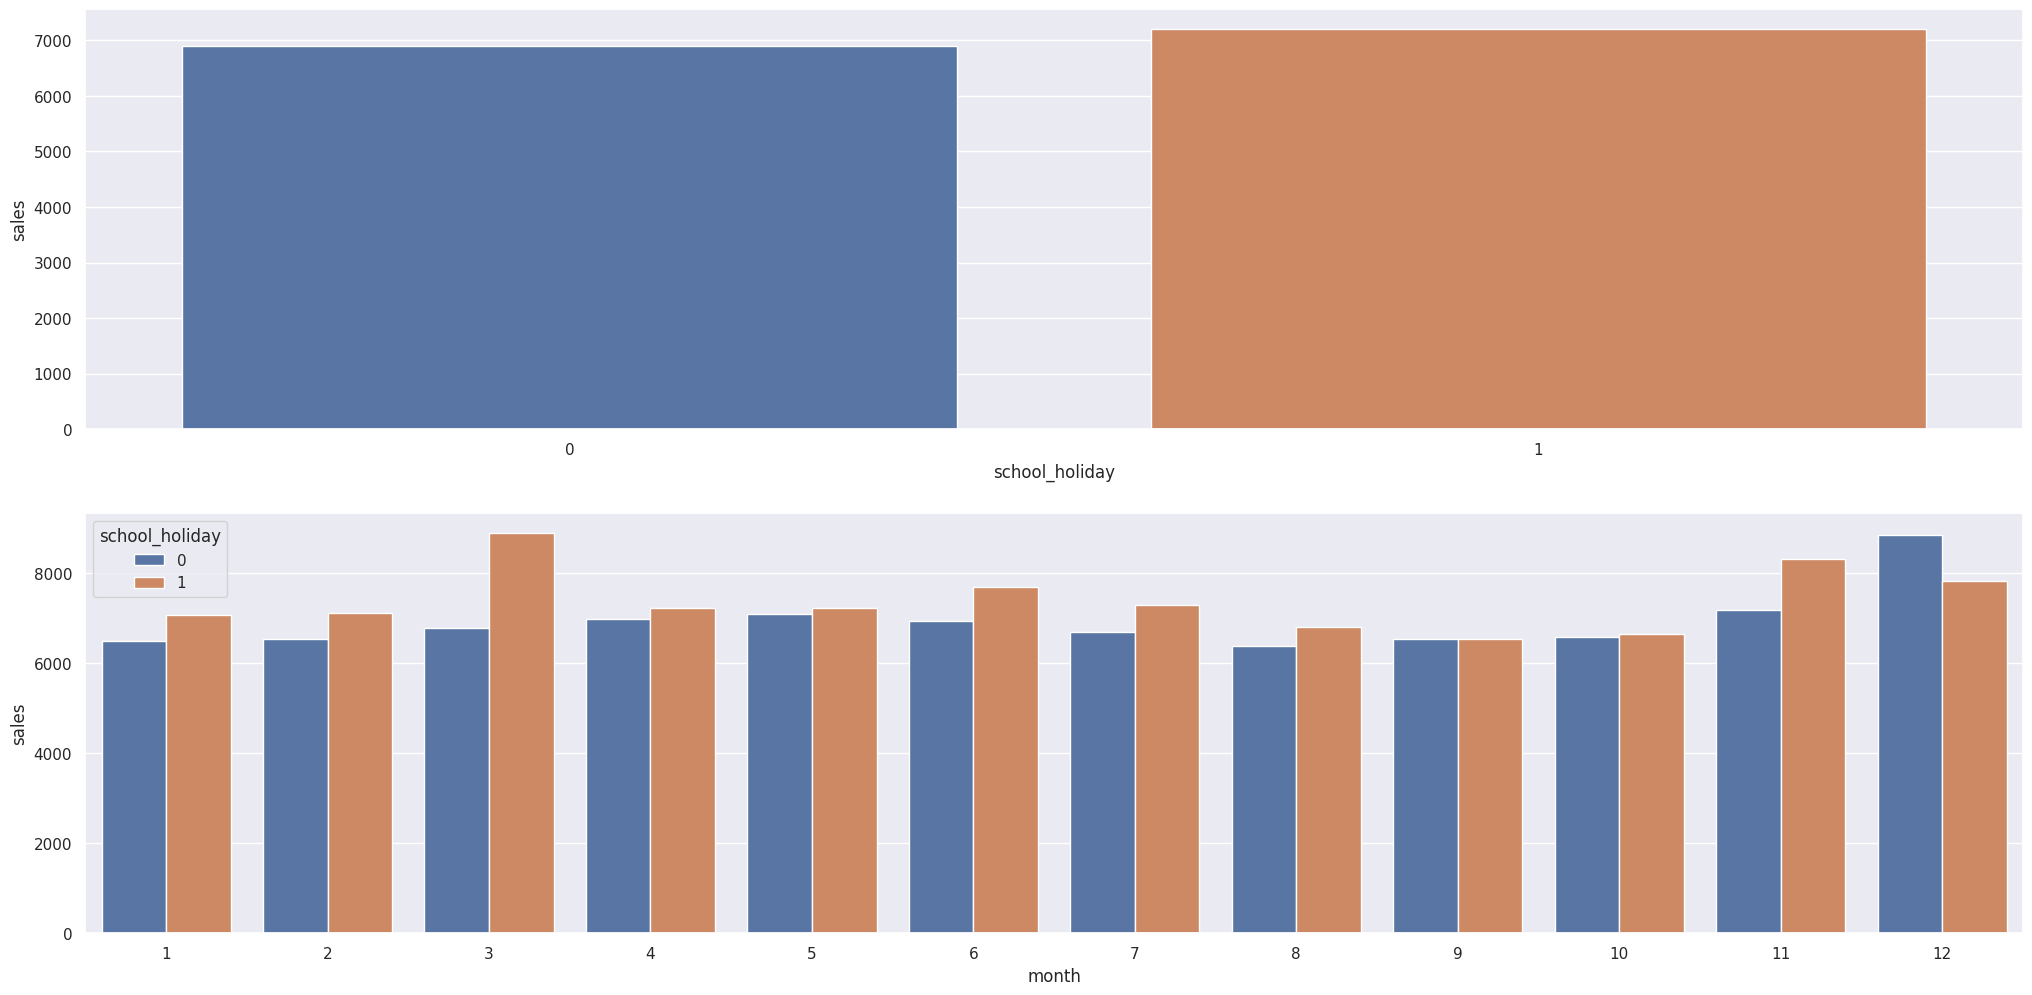

In [49]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

# 4.3 Análise Multivariada

# 4.3.1 Num Attributes

<AxesSubplot: >

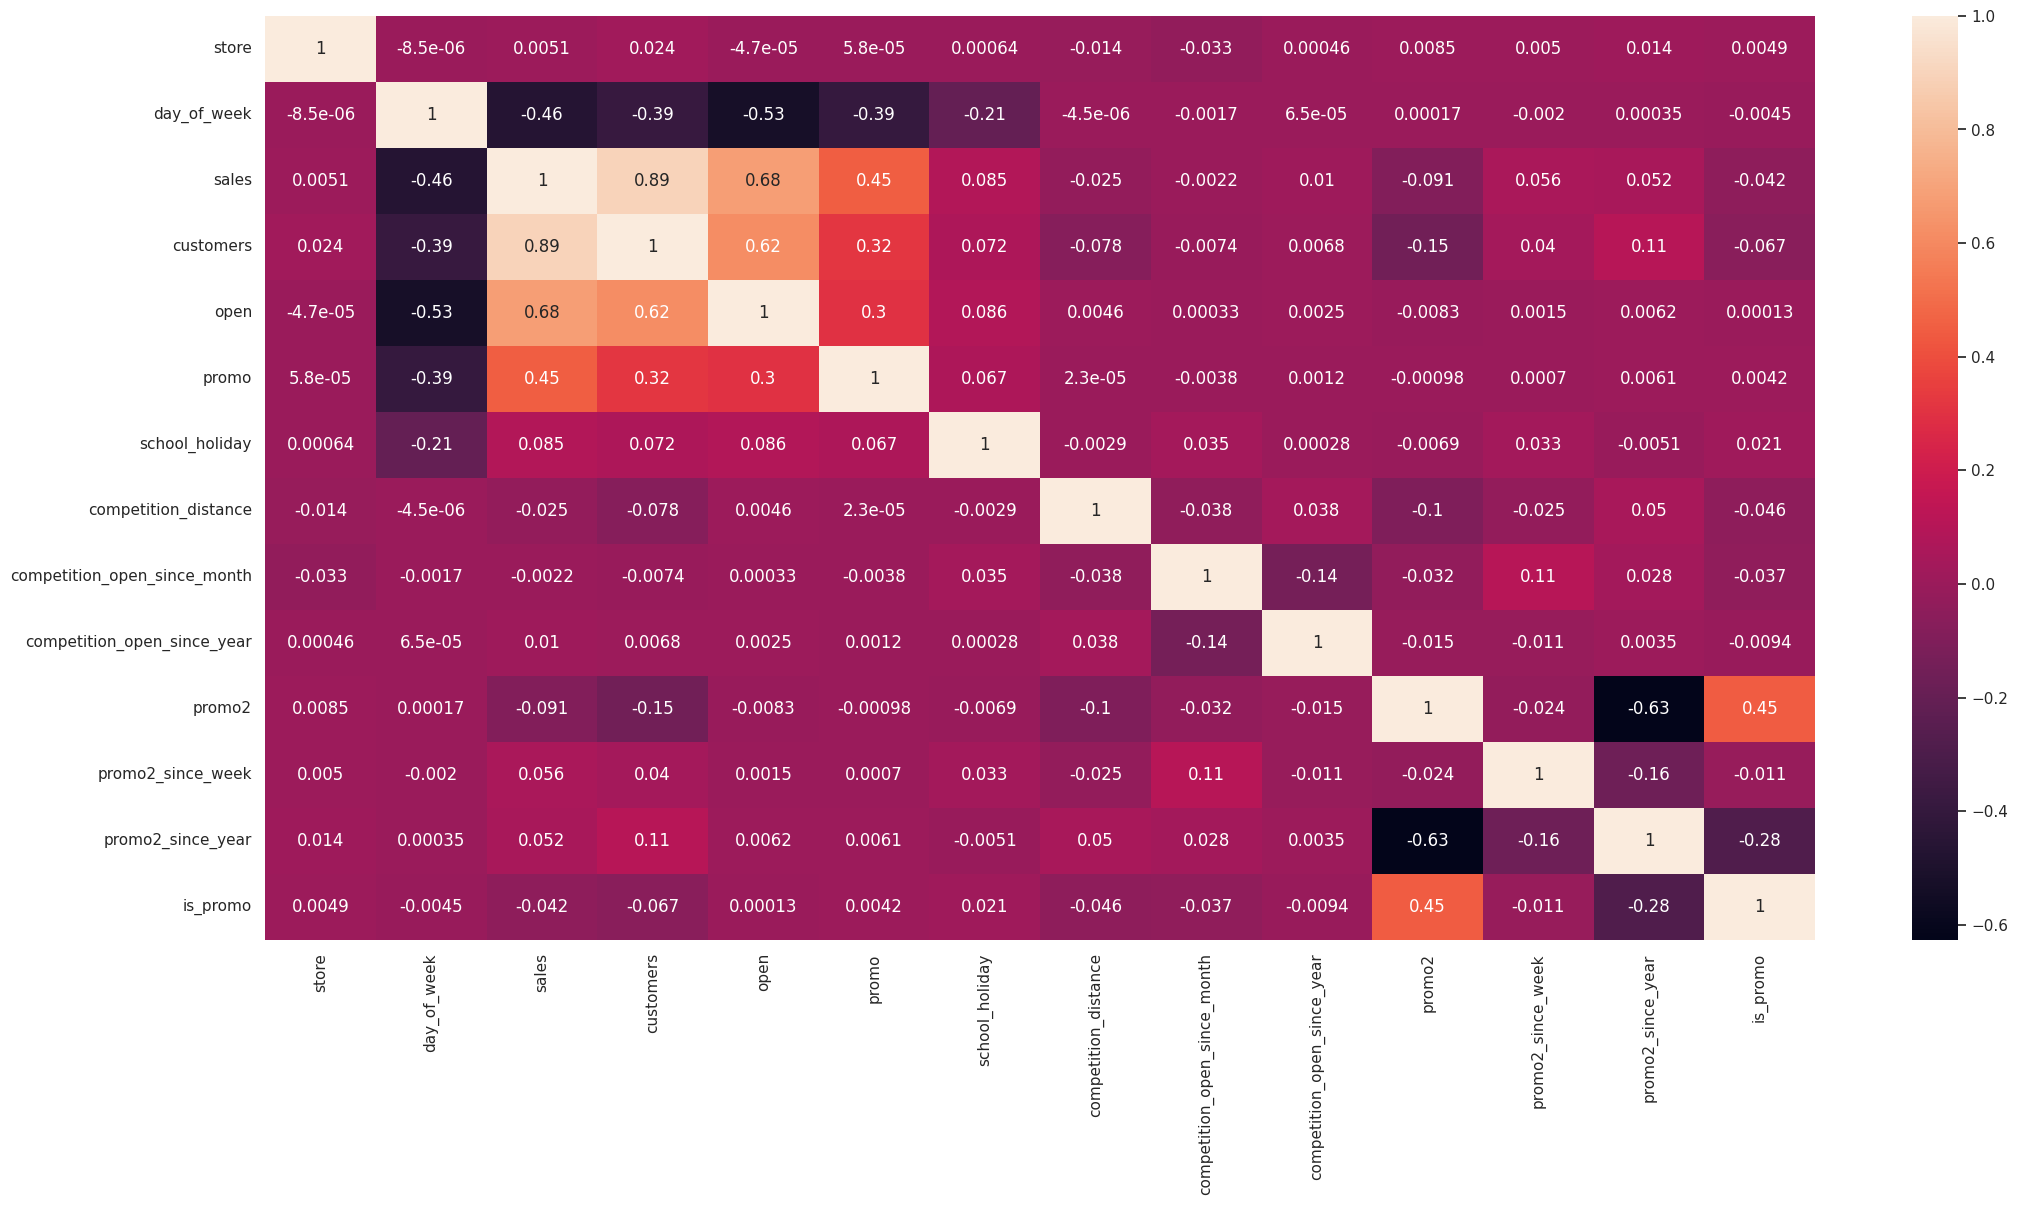

In [50]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

# 4.3.1 Cat Attributes

In [51]:
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot: >

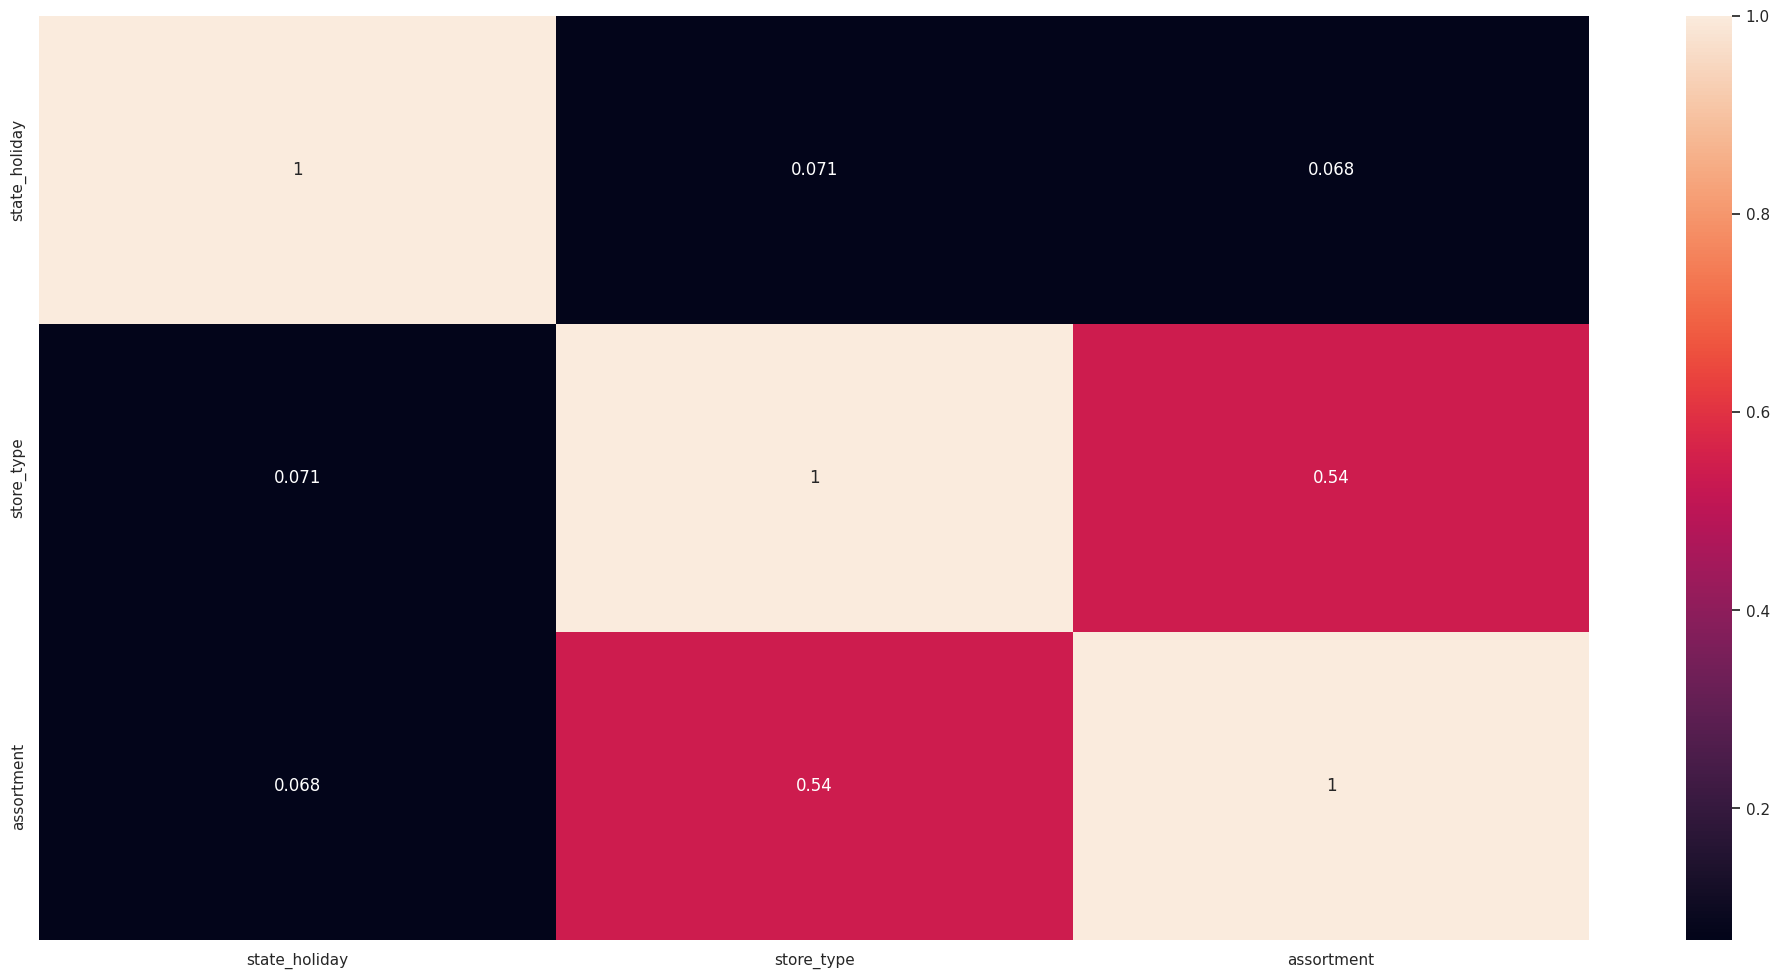

In [52]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [53]:
df5 = df4.copy()

# 5.1 Normalização

In [54]:
#olhando a análise variada, em especifico os atributos numéricos, não há nenhuma distribuição normal logo não vai ocorrer a normalização

# 5.2 Rescaling

In [55]:
a = df5.select_dtypes(include = ['float64','int32','int64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [56]:
#verificando os outliers para aplicar os metodos min/max ou robustescale
#sns.boxplot(df5['competition_distance'])
#sns.boxplot(df5['competition_time_month'])
#sns.boxplot(df5['promo_time_week'])

In [57]:
#quando se tem outliers destoando, aplicamos o robust Scaler pois o MinMax é sensivel aos outliers
#RobustScaler deixa a distribuição mais 'apertada'
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/encoding_competition_distance_scaler.pkl','wb'))
#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/encoding_year_scaler.pkl','wb'))
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/encoding_competition_time_month.pkl','wb'))
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/encoding_promo_time_week.pkl','wb'))

<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

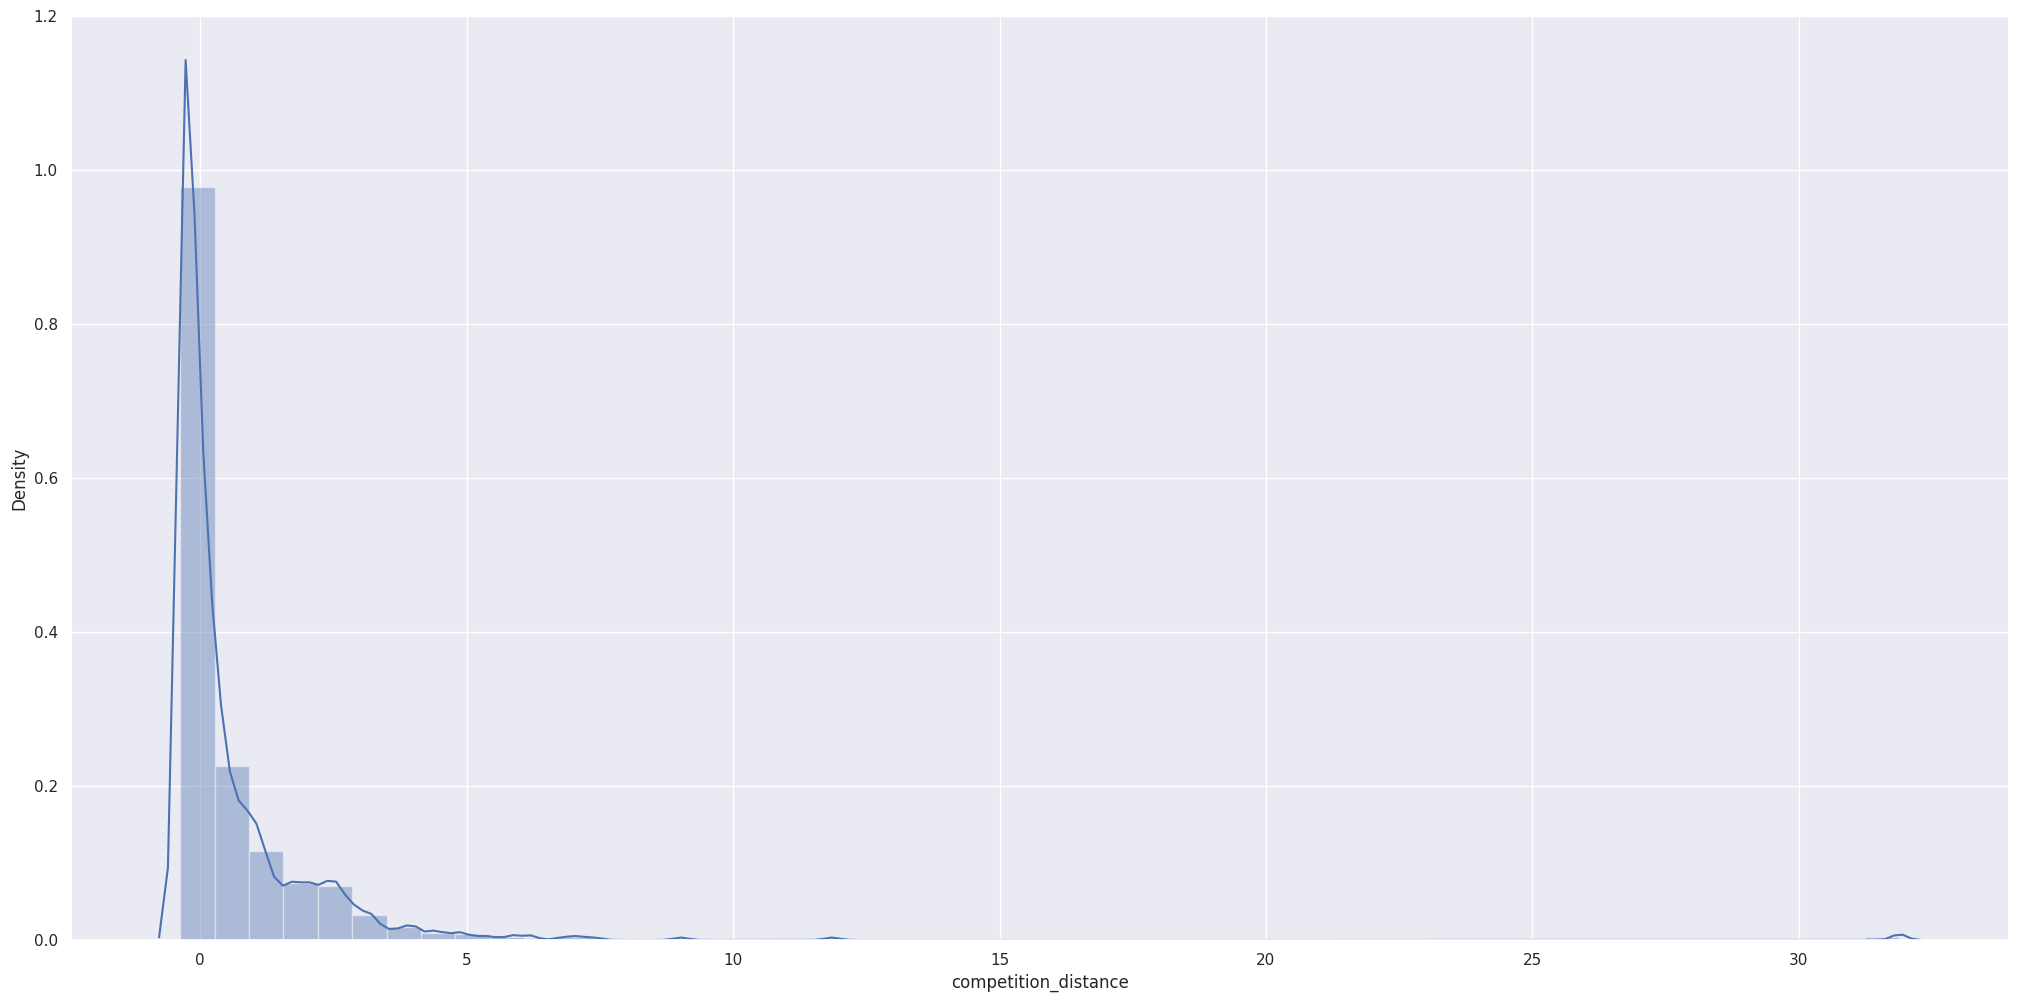

In [58]:
sns.distplot(df5['competition_distance'])

# 5.3 Transformação

# 5.3.1 Encoding
Transforma variáveis categóricas em numericas

In [59]:
#state_holiday = One Hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'],columns = ['state_holiday'])
#store_type = laBel encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))
#assortment = Ordinal encoding
assortment_dict = {'basic':1,
                   'extra':2,
                   'extended':3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

# 5.3.2 Response variable transformation

In [60]:
df5['sales'] = np.log1p(df5['sales'])

# 5.3.3 Nature transformation Cíclico

In [61]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [62]:
df6 = df5.copy()

# 6.1 Split Dataframe into training and test dataset

In [63]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [64]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [65]:
#df6[['store','date']].groupby('store').min().reset_index()
#pegar 6 semanas antes do tempo máximo pra ter como base na predição das vendas das 6 semanas após
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [66]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test_dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print('Training Min Date:{}'.format(X_train['date'].min()))
print('Training Max Date:{}'.format(X_train['date'].max()))
      
print('Test Min Date:{}'.format(X_test['date'].min()))
print('Test Max Date:{}'.format(X_test['date'].max()))

Training Min Date:2013-01-01 00:00:00
Training Max Date:2015-06-18 00:00:00
Test Min Date:2015-06-20 00:00:00
Test Max Date:2015-07-31 00:00:00


# 6.2 Boruta as Feature Selector

In [67]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [68]:
#training and test dataset
#X_train_n = X_train.drop(['date','sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

#defineRandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto',verbose = 2,random_state = 42).fit(X_train_n,y_train_n)

In [69]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modelling

In [71]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
#Time Series Data preparation
x_training = X_train[cols_selected_boruta_full]

# 7.1 Average Model

In [72]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [73]:
#def ml_error(model_name,y, yhat):
   # mae = mean_absolute_error(y,yhat)
   # mape = mean_absolute_percentage_error(y , yhat)
   # rmse = np.sqrt(mean_squared_error(y , yhat))
    
   # return pd.DataFrame( {'Model Name': model_name,
                     #     'MAE': mae,
                        #  'MAPE':mape,
                       #   'RMSE': rmse}, index = [0])

In [74]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on ='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.207912,1854.263316


# 7.2 Linear Regression Model

In [75]:
#model
lr = LinearRegression().fit(x_train, y_train)
#prediction
yhat_lr = lr.predict(x_test)
#performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.73952,0.293745,2675.947846


# 7.2.1 Linear Regression Model - Cross Validation

In [76]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression',lr,verbose=False)
lr_result_cv

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  2646.613114  0.311344  3821.440986
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1919.968461  0.328446  2587.410734
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1814.710176  0.305484  2535.498149
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  2076.515631  0.286507  3014.787943
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1985.645061  0.284691  2850.375942


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2088.69+/-291.75,0.3+/-0.02,2961.9+/-463.92


# 7.3 Linear Regression Regularized Model - Lasso

In [77]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)
#prediction
yhat_lrr = lr.predict(x_test)
#performance
lrr_result = ml_error( 'Linear Regression', np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.879201,0.290664,2688.11216


# 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [78]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso',lrr,verbose=False)
lrr_result_cv

  Model Name          MAE      MAPE         RMSE
0      Lasso  2751.273254  0.314421  3975.726486
  Model Name         MAE      MAPE         RMSE
0      Lasso  1856.51872  0.290631  2642.330399
  Model Name          MAE      MAPE         RMSE
0      Lasso  1819.099216  0.290164  2608.513371
  Model Name          MAE      MAPE         RMSE
0      Lasso  2170.766785  0.285909  3184.622204
  Model Name          MAE      MAPE         RMSE
0      Lasso  2020.782625  0.281306  2931.083261


,Model Name,MAE,MAPE,RMSE
0,Lasso,2123.69+/-337.88,0.29+/-0.01,3068.46+/-499.73


# 7.4 Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1, random_state = 42).fit(x_train,y_train)


#prediction

yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.645619,0.100166,1013.229531


# 7.4.1 Random Forest Regressor - Cross Validation

In [80]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor',rf,verbose=False)
rf_result_cv

                Model Name          MAE      MAPE         RMSE
0  Random Forest Regressor  1207.659899  0.149893  1787.697416
                Model Name         MAE      MAPE        RMSE
0  Random Forest Regressor  884.246552  0.134977  1335.06573
                Model Name         MAE      MAPE        RMSE
0  Random Forest Regressor  553.514808  0.088616  857.344849
                Model Name        MAE      MAPE         RMSE
0  Random Forest Regressor  862.43693  0.110305  1317.226077
                Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  701.636743  0.097995  1010.694506


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,841.9+/-218.56,0.12+/-0.02,1261.61+/-319.89


# 7.5 XGBoost

In [81]:
import xgboost as xgb

In [82]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100,eta = 0.01, max_depth= 10, subsample = 0.7,colsample_bytree = 0.9).fit(x_train,y_train)


#prediction

yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6667.655567,0.949398,7320.620884


# 7.5.1 XGBoost - Cross Validation

In [83]:
model_xgb_result_cv = cross_validation(x_training, 5, 'XGBoost',model_xgb,verbose=False)
model_xgb_result_cv

  Model Name          MAE      MAPE         RMSE
0    XGBoost  8062.160416  0.953641  8905.775676
  Model Name          MAE     MAPE         RMSE
0    XGBoost  6609.433639  0.94885  7189.760315
  Model Name          MAE      MAPE         RMSE
0    XGBoost  6412.725096  0.949002  6986.895584
  Model Name          MAE      MAPE         RMSE
0    XGBoost  7235.386238  0.952333  7958.643984
  Model Name          MAE      MAPE        RMSE
0    XGBoost  6987.436031  0.952366  7612.17383


,Model Name,MAE,MAPE,RMSE
0,XGBoost,7061.43+/-576.6,0.95+/-0.0,7730.65+/-677.15


# 7.6 Compare Model´s Performance

# 7.6.1 Single Performance

In [84]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.645619,0.100166,1013.229531
0,Average Model,1366.128351,0.207912,1854.263316
0,Linear Regression,1868.739520,0.293745,2675.947846
0,Linear Regression,1868.879201,0.290664,2688.112160
0,XGBoost Regressor,6667.655567,0.949398,7320.620884


# 7.6.2 Real Performance - Cross Validation

In [85]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,model_xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,841.9+/-218.56,0.12+/-0.02,1261.61+/-319.89
0,Linear Regression,2088.69+/-291.75,0.3+/-0.02,2961.9+/-463.92
0,Lasso,2123.69+/-337.88,0.29+/-0.01,3068.46+/-499.73
0,XGBoost,7061.43+/-576.6,0.95+/-0.0,7730.65+/-677.15


# 8.0 Hyperparameter fine tunning

# 8.1 Random Search

In [86]:
import random
import warnings
warnings.filterwarnings('ignore')

In [87]:
param = {
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight': [3,8,15] 
         }

MAX_EVAL = 10

In [88]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
    #choose values for parameters randomly
 #   hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
 #   print(hp)

    #model
  #  model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
    #                             n_estimators=hp['n_estimators'],
    #                             eta = hp['eta'], 
    #                             max_depth= hp['max_depth'],
    #                             subsample =hp['subsample'],
    #                             colsample_bytree =hp['colsample_bytree'] ,
    #                             min_child_weight = hp['min_child_weight'])


    

    #performance
   # result =    cross_validation(x_training,2,'XGBoost Regressor',model_xgb,verbose = False)
   # final_result = pd.concat([final_result,result])
#final_result

# 8.2 Final Model

In [89]:
param_tuned = {
    'n_estimators':1700,
    'eta':0.03,
    'max_depth':9,
    'subsample':0.5,
    'colsample_bytree':0.3,
    'min_child_weight':15  
         }



In [90]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators=param_tuned['n_estimators'],
                                 eta = param_tuned['eta'],
                                 max_depth= param_tuned['max_depth'],
                                 subsample =param_tuned['subsample'],
                                 colsample_bytree =param_tuned['colsample_bytree'] ,
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train,y_train)


#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,690.077731,0.10261,990.781052


In [91]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tuned))

# 9.0 Tradução e interpretação do erro

In [92]:
df9 = X_test[cols_selected_boruta_full]
#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# 9.1 Business Performance

In [93]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91,df9_aux3, how= 'inner', on = 'store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order_columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [94]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,99910.789062,96377.357083,103444.221042,3533.431980,0.617799
908,909,225585.250000,217617.979514,233552.520486,7967.270486,0.542945
875,876,191518.000000,187431.521906,195604.478094,4086.478094,0.320351
169,170,184777.453125,183719.041863,185835.864387,1058.411262,0.262724
285,286,154163.687500,153504.789734,154822.585266,658.897766,0.246443


<AxesSubplot: xlabel='store', ylabel='MAPE'>

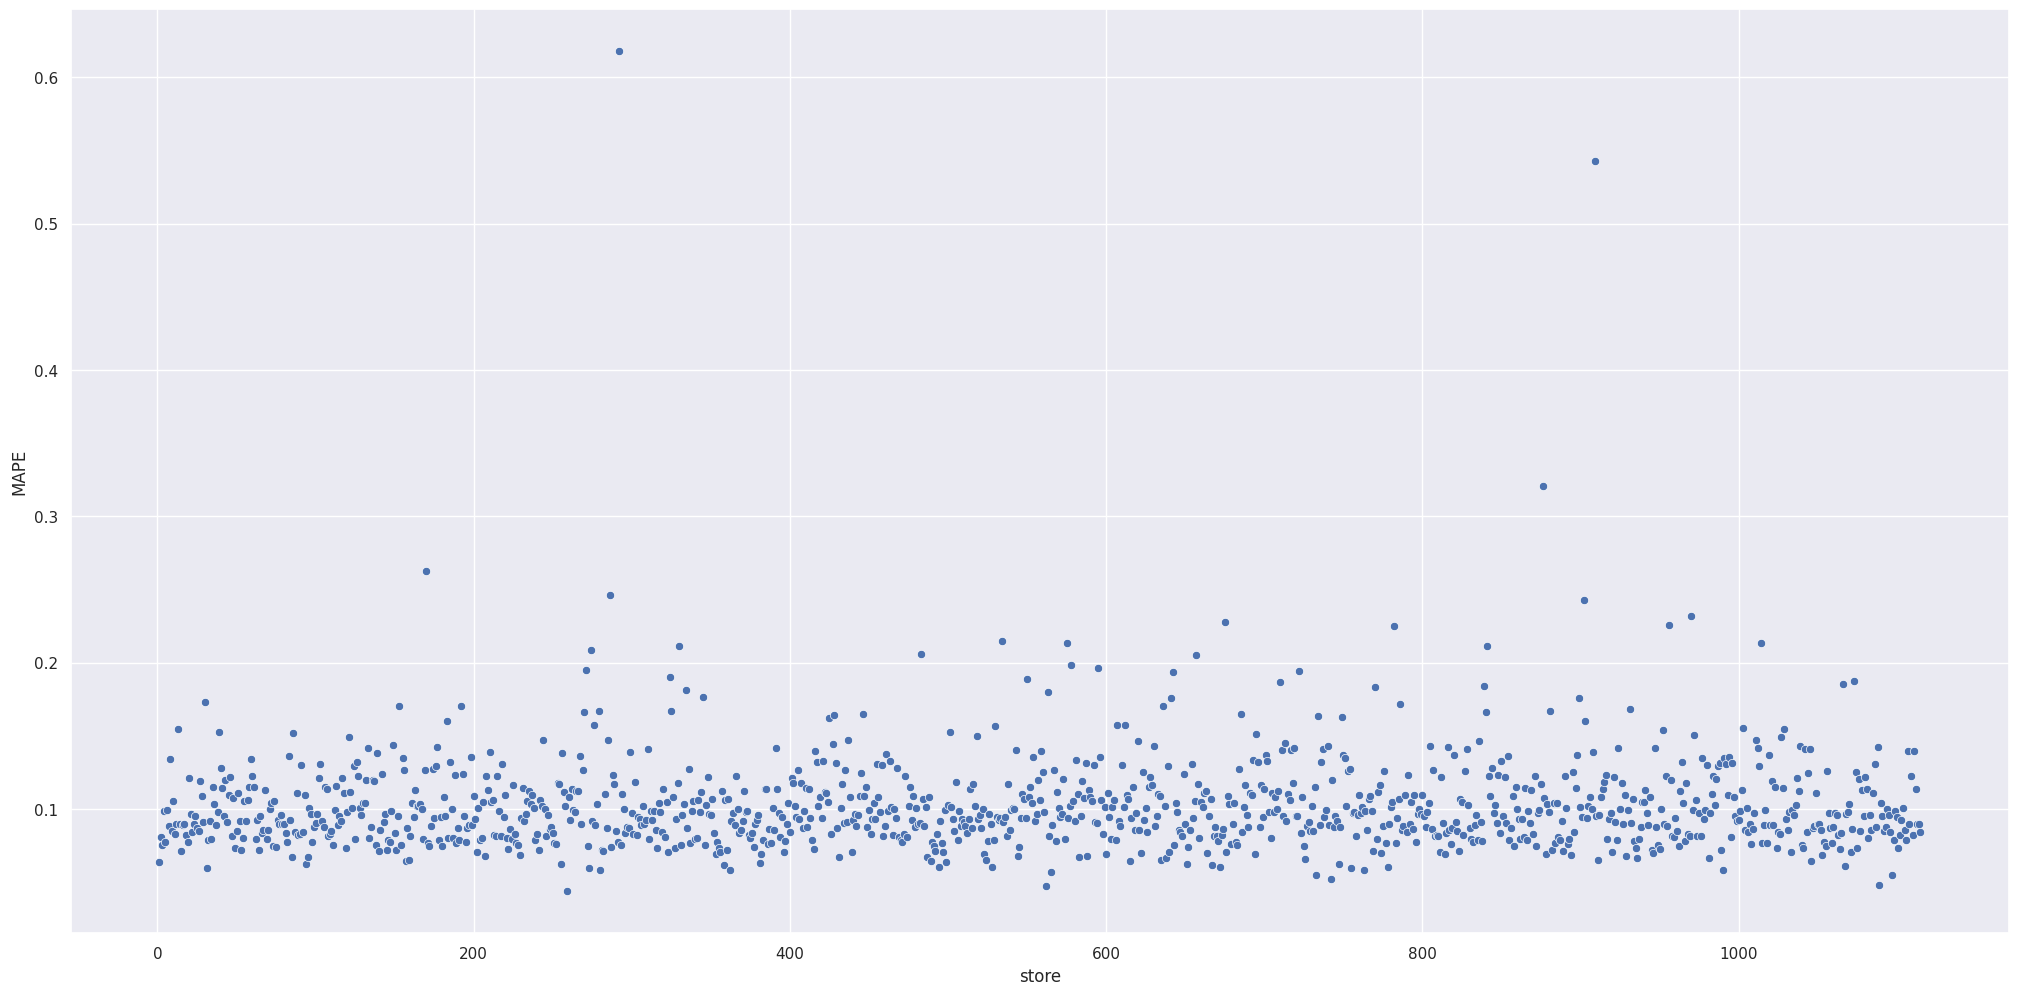

In [95]:
sns.scatterplot(x = 'store', y = 'MAPE',data=df92)

# 9.2 Total perfomance

In [96]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns = {'index':'Scenario',0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$277,532,192.00"
1,worst_scenario,"R$276,758,401.30"
2,best_scenario,"R$278,306,002.42"


# 9.3 Machine learning performance

In [97]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

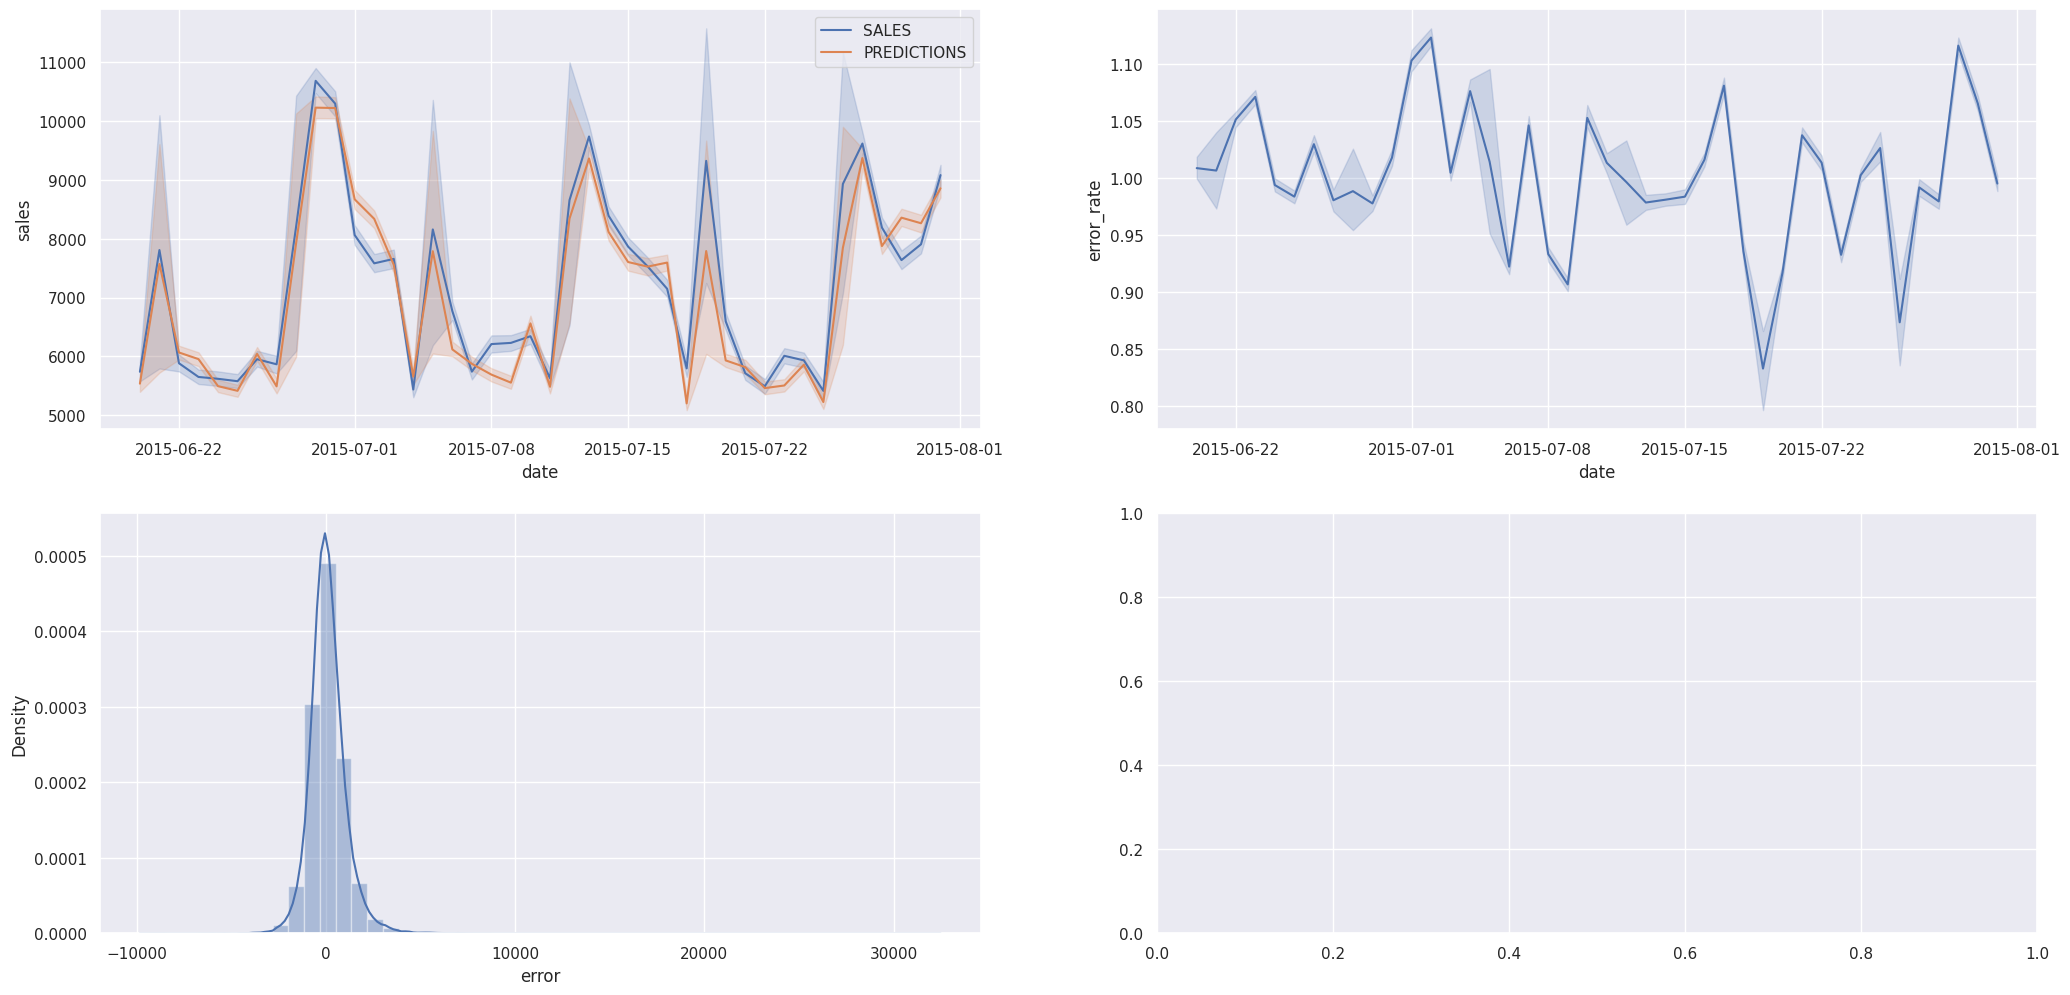

In [98]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales',data=df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions',data=df9, label = 'PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate',data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])

# 10.0 Deploy model to production

In [ ]:
import pickle
pickle.dump(model_xgb_tuned, open('model_rossman.pkl','wb'))

# 10.1 Rossman Class

In [ ]:
class Rossmann(object):
    def __init__(self):
        self.encoding_competition_distance_scaler   = pickle.load( open('parameter/encoding_competition_distance_scaler.pkl','rb'))
        self.encoding_competition_time_month        = pickle.load( open('parameter/encoding_competition_time_month.pkl','rb'))
        self.encoding_promo_time_week               = pickle.load( open('parameter/encoding_promo_time_week.pkl','rb'))
        self.encoding_year_scaler                   = pickle.load( open('parameter/encoding_year_scaler.pkl','rb'))
        self.store_type_scaler                      = pickle.load( open('parameter/store_type_scaler.pkl','rb'))
        
    def data_cleaning(self , df1):
        
        # 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x : inflection.underscore(x)
        cols_new = list(map(snakecase,cols_old))

        #rename
        df1.columns = cols_new




        # 1.3 Data types

        df1['date'] = pd.to_datetime( df1['date'])


        # 1.5 Fillout NA

        #competition_distance
        df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval
        month_map = {1:'Jan',2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo']= df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)



        # 1.6 change types


        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
    

        #year
        df2['year'] = df2['date'].dt.year
        #month

        df2['month'] = df2['date'].dt.month
        #day
        df2['day'] = df2['date'].dt.day
        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        #competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        # 3.1. Filtragem das Linhas

        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        # 3.2. Selecao das Colunas

        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    
    def data_preparation(self,df5):
        
        # 5.0 Data Preparation

        # 5.1 Normalização

        #olhando a análise variada, em especifico os atributos numéricos, não há nenhuma distribuição normal logo não vai ocorrer a normalização

        # 5.2 Rescaling

        #competition_distance
        df5['competition_distance'] = self.encoding_competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        #year
        df5['year'] = self.encoding_year_scaler.transform(df5[['year']].values)

        #competition time month
        df5['competition_time_month'] = self.encoding_competition_time_month.transform(df5[['competition_time_month']].values)
        
        #promo time week
        df5['promo_time_week'] = self.encoding_promo_time_week.transform(df5[['promo_time_week']].values)


        # 5.3 Transformação

        # 5.3.1 Encoding

        #state_holiday = One Hot encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'],columns = ['state_holiday'])
        #store_type = laBel encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
        
        #assortment = Ordinal encoding
        assortment_dict = {'basic':1,
                           'extra':2,
                           'extended':3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # 5.3.3 Nature transformation Cíclico

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        cols_selected = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos']

        
        return df5[cols_selected]
    
    
     def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

# 10.2 API Handler Class

In [ ]:
import pickle
import pandas as pd
from flask             import Flask,request,Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('/home/mattheus/rossmann/model_rossman.pkl','rb'))

#iniatialize api
app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            text_raw = pd.DataFrame(test_json, index = [0])
        else:
            text_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        #instantiate rossman class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        #data preparation
        df3 = pipeline.data_preparation(df2)
        #prediction
        
        df_response = pipeline.get_prediction(model, test_raw,df3)
        
        return df_response
        
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
if __name__ == '__main__':
    app.run('0.0.0.0')

# 10.3 API Tester